In [117]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import pandas as pd

import scipy.stats as ss
from scipy import linalg  # numpy linalg plus extras
import statsmodels.api as sm

import scipy.io as spio
# import matlab.engine

In [41]:
# directories
datadir='/data1/adac/'
processdir=datadir + 'process/'

In [20]:
# regions
class AdACRegion(object):
    def __init__(self, name=None, lon=None, lat=None):
        if name is None:
            raise ValueError("name must be specified")
        self.name = name
        self.lon = lon
        self.lat = lat
    def __str__(self):
        return "%s, %f, %f" % (self.name, self.lon, self.lat)
regions=[AdACRegion('WesternMed',3,38.5),
         AdACRegion('ROAM_MIZ',3.18,61.58)]


2


In [101]:
# swath file
swfile=datadir + 'ephem_calval_june2015_ell-v2.txt';
print("loading " + swfile)

data=np.loadtxt(swfile,skiprows=4)
swt=data[:,0]
swx=data[:,1]
swy=data[:,2]
# shift lon axis:
# swx[swx>180]=swx[swx>180]-360;
swx[swx>180]-=360;
# % get rid of big jumps
swxm = np.ma.asarray(swx)
dswx=abs(np.diff(swx))
dswx=np.hstack((dswx,0))
ji=dswx>200
swxm[ji] = np.ma.masked
swx=swxm.flatten()

loading /data1/adac/ephem_calval_june2015_ell-v2.txt


In [702]:
# load segmented TSG data
tsgfile=processdir + 'adac_tsg_segments.txt'
print('loading %s' % tsgfile)
# data=np.loadtxt(tsgfile,skiprows=1)
nrows=None # set to some value <50000 for testing
tsg = pd.read_csv(tsgfile, sep=',', header=0,engine='python',nrows=nrows)
tsg.head()

loading /data1/adac/process/adac_tsg_segments.txt


,x,y,t,dist,T,S,D,speed,callsign
0,-169.138504,-14.608500,733594.267361,0.0,NaN,35.165001,NaN,7.409730,1.0
1,-169.115631,-14.612450,733594.271258,2.5,NaN,35.150407,NaN,7.544748,1.0
2,-169.092772,-14.616475,733594.275098,5.0,NaN,35.136924,NaN,7.445929,1.0
3,-169.069880,-14.620325,733594.278983,7.5,NaN,35.129654,NaN,7.454520,1.0
4,-169.046965,-14.624050,733594.282865,10.0,NaN,35.129466,NaN,7.533735,1.0


In [720]:
# variable names:
avars=['x','y','t','callsign'] # non-data variables
datavars=['T','S','D'] # data variables
allvars=avars + datavars
# initialize dataframes:
data_av=pd.DataFrame(columns=allvars)
data_std=pd.DataFrame(columns=datavars)

# loop through segments
x=tsg["x"] # x = -9999 denotes end of a segment 
# index of x=-9999 values
# ibreak=[i for i, x in enumerate(x) if x==-9999]
ibreak=[i for i, x in enumerate(x) if np.isnan(x)]
ibreak=ibreak#[:1]
# --- specify earlier ---
dwinkm=20 # vary this
DGRID=2.5  # fundamental to the data
dwinpts=int(np.floor(dwinkm/DGRID)+1);  # datapoints per window


# loop through ibreak, which indicate the end of a segment
seg0=0
Ntot=0
for segi in ibreak:
    # index of this segment
    thisi=range(seg0,segi)
#     print('segment ending with ' , segi , ' length ' , segi-seg0)
    seg=tsg.iloc[thisi]
    # increment seg0 * check this *
    seg0=segi+1
    # break into XX-km windows and compute metrics over these windows
    dseg=np.max(seg.dist);
    Nwindows=int(np.floor(seg.shape[0]/dwinpts));    Ntot+=Nwindows
    # index of this window
    win=range(0,int(Nwindows*dwinpts)) # too long?              
    seg_win=seg.iloc[win]
    # for each variable in seg_win, 
    # reshape so that each COLUMN of seg_win is a "dwinkm" window of data
    
    thisstd=[] # reinitialize for each segment
    for v in datavars:
        # reshape into a matrix
        var_win=np.array(seg_win[v]).reshape(dwinpts,Nwindows)
        # check for bad values using masked array
#         var_win_ma = np.ma.array(var_win,mask=-9999)
#         var_win_ma = np.ma.masked_invalid(var_win_ma)
        # metrics: mean/std will have length dwinpts
        # to add them to the pandas dataframe, we need to stick all 
        # the variables together 
        dum=np.nanstd(var_win,axis=0)
        thisstd=np.concatenate((thisstd,dum))
    # once we've looped through all variables:
    thisstd=thisstd.reshape(3,dum.shape[0]).T # std of T/S/D for this segment
    # append to the dataframe
    newdata=pd.DataFrame(thisstd,columns=datavars)
    data_std=data_std.append(newdata,ignore_index=True)
    stddata=newdata
    
    # loop through *all* variables to get mean:
    thisav=[] # reinitialize for each segment
    for v in allvars:
        var_win=np.array(seg_win[v]).reshape(dwinpts,Nwindows)
#         # check for bad values using masked array XXX doesn't work
#         var_win_ma = np.ma.array(var_win,mask=-9999)
#         var_win_ma = np.ma.masked_invalid(var_win_ma)
        # metrics: mean/std will have length dwinpts
        # to add them to the pandas dataframe, we need to stick all 
        # the variables together 
#         dum=np.mean(var_win_ma,axis=0)
        dum=np.nanmean(var_win,axis=0)
        thisav=np.concatenate((thisav,dum)) 
#         if v=='x':
#             print('variable ', v,': ', var_win[0,:])
#             print('\t mean ',thisav)
    # once we've looped through all variables:
    thisav=thisav.reshape(7,dum.shape[0]).T # mean of *all* vars for this segment
#     print(thisav)
    # append to the dataframe
    newdata=pd.DataFrame(thisav,columns=allvars)
    data_av=data_av.append(newdata,ignore_index=True)
    # ** add "N" - # of data in mean/std

    meandata=newdata
    print('std data size ', stddata.shape, ' mean data size ',meandata.shape)
    
    

[139, 635, 716, 759, 1302, 1412, 2214, 2858, 4025, 4202, 4686, 4873, 4923, 4979, 5167, 5515, 5644, 6232, 6295, 6451, 6507, 6591, 7227, 7312, 7521, 7565, 7622, 7720, 7990, 8140, 8315, 8450, 8760, 8813, 8858, 8923, 8978, 9190, 9472, 9713, 10993, 11629, 11713, 11782, 11902, 11955, 12200, 12277, 12652, 12772, 12841, 12892, 13509, 13584, 13635, 13770, 13838, 14018, 14073, 14172, 14225, 14604, 14703, 14821, 14874, 15046, 15414, 15488, 15591, 15739, 15791, 15833, 15948, 16159, 16201, 16246, 16302, 16355, 16403, 16449, 16499, 16557, 16614, 16688, 16764, 16816, 17572, 17735, 18120, 18225, 18343, 18961, 19036, 19308, 19914, 20101, 20423, 20550, 20811, 20930, 21047, 21368, 21842, 21991, 22114, 22176, 22343, 22923, 23358, 23569, 23637, 23703, 23986, 24599, 25174, 25351, 25474, 25848, 25944, 25988, 26055, 26277, 26388, 26439, 26590, 26752, 26869, 27011, 27166, 27311, 27377, 27438, 27692, 27796, 27901, 28053, 28173, 28235, 28446, 28489, 28531, 28591, 28638, 28693, 28889, 28943, 29115, 29282, 29339, 

/home/kdrushka/miniconda3/envs/py37/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
<ipython-input-720-bf80cc88d109>:71: RuntimeWarning: Mean of empty slice
  dum=np.nanmean(var_win,axis=0)


std data size  (7, 3)  mean data size  (7, 7)
segment ending with  12892  length  50
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  13509  length  616
std data size  (68, 3)  mean data size  (68, 7)
segment ending with  13584  length  74
std data size  (8, 3)  mean data size  (8, 7)
segment ending with  13635  length  50
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  13770  length  134
std data size  (14, 3)  mean data size  (14, 7)
segment ending with  13838  length  67
std data size  (7, 3)  mean data size  (7, 7)
segment ending with  14018  length  179
std data size  (19, 3)  mean data size  (19, 7)
segment ending with  14073  length  54
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  14172  length  98
std data size  (10, 3)  mean data size  (10, 7)
segment ending with  14225  length  52
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  14604  length  378
std data size  (42, 3)  mean data size  (42, 7)
segme

std data size  (9, 3)  mean data size  (9, 7)
segment ending with  37474  length  143
std data size  (15, 3)  mean data size  (15, 7)
segment ending with  37533  length  58
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  37591  length  57
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  37641  length  49
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  37696  length  54
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  37791  length  94
std data size  (10, 3)  mean data size  (10, 7)
segment ending with  37874  length  82
std data size  (9, 3)  mean data size  (9, 7)
segment ending with  37939  length  64
std data size  (7, 3)  mean data size  (7, 7)
segment ending with  38217  length  277
std data size  (30, 3)  mean data size  (30, 7)
segment ending with  38263  length  45
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  38389  length  125
std data size  (13, 3)  mean data size  (13, 7)
segment 

std data size  (12, 3)  mean data size  (12, 7)
segment ending with  62519  length  49
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  62598  length  78
std data size  (8, 3)  mean data size  (8, 7)
segment ending with  62726  length  127
std data size  (14, 3)  mean data size  (14, 7)
segment ending with  62796  length  69
std data size  (7, 3)  mean data size  (7, 7)
segment ending with  62884  length  87
std data size  (9, 3)  mean data size  (9, 7)
segment ending with  63030  length  145
std data size  (16, 3)  mean data size  (16, 7)
segment ending with  63082  length  51
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  63147  length  64
std data size  (7, 3)  mean data size  (7, 7)
segment ending with  63460  length  312
std data size  (34, 3)  mean data size  (34, 7)
segment ending with  63600  length  139
std data size  (15, 3)  mean data size  (15, 7)
segment ending with  63649  length  48
std data size  (5, 3)  mean data size  (5, 7)
segme

std data size  (28, 3)  mean data size  (28, 7)
segment ending with  73614  length  50
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  74101  length  486
std data size  (54, 3)  mean data size  (54, 7)
segment ending with  74222  length  120
std data size  (13, 3)  mean data size  (13, 7)
segment ending with  74458  length  235
std data size  (26, 3)  mean data size  (26, 7)
segment ending with  74552  length  93
std data size  (10, 3)  mean data size  (10, 7)
segment ending with  74600  length  47
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  74663  length  62
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  74725  length  61
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  74790  length  64
std data size  (7, 3)  mean data size  (7, 7)
segment ending with  74860  length  69
std data size  (7, 3)  mean data size  (7, 7)
segment ending with  74909  length  48
std data size  (5, 3)  mean data size  (5, 7)
segmen

std data size  (5, 3)  mean data size  (5, 7)
segment ending with  84085  length  92
std data size  (10, 3)  mean data size  (10, 7)
segment ending with  84130  length  44
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  84211  length  80
std data size  (8, 3)  mean data size  (8, 7)
segment ending with  84253  length  41
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  84342  length  88
std data size  (9, 3)  mean data size  (9, 7)
segment ending with  84414  length  71
std data size  (7, 3)  mean data size  (7, 7)
segment ending with  84508  length  93
std data size  (10, 3)  mean data size  (10, 7)
segment ending with  84660  length  151
std data size  (16, 3)  mean data size  (16, 7)
segment ending with  84783  length  122
std data size  (13, 3)  mean data size  (13, 7)
segment ending with  84825  length  41
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  85112  length  286
std data size  (31, 3)  mean data size  (31, 7)
segmen

std data size  (8, 3)  mean data size  (8, 7)
segment ending with  96136  length  41
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  96409  length  272
std data size  (30, 3)  mean data size  (30, 7)
segment ending with  96631  length  221
std data size  (24, 3)  mean data size  (24, 7)
segment ending with  96690  length  58
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  96820  length  129
std data size  (14, 3)  mean data size  (14, 7)
segment ending with  96928  length  107
std data size  (11, 3)  mean data size  (11, 7)
segment ending with  97030  length  101
std data size  (11, 3)  mean data size  (11, 7)
segment ending with  97113  length  82
std data size  (9, 3)  mean data size  (9, 7)
segment ending with  97192  length  78
std data size  (8, 3)  mean data size  (8, 7)
segment ending with  97293  length  100
std data size  (11, 3)  mean data size  (11, 7)
segment ending with  97361  length  67
std data size  (7, 3)  mean data size  (7, 7)
s

std data size  (5, 3)  mean data size  (5, 7)
segment ending with  105796  length  71
std data size  (7, 3)  mean data size  (7, 7)
segment ending with  105915  length  118
std data size  (13, 3)  mean data size  (13, 7)
segment ending with  105982  length  66
std data size  (7, 3)  mean data size  (7, 7)
segment ending with  106024  length  41
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  106154  length  129
std data size  (14, 3)  mean data size  (14, 7)
segment ending with  106215  length  60
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  106263  length  47
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  106358  length  94
std data size  (10, 3)  mean data size  (10, 7)
segment ending with  106414  length  55
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  106501  length  86
std data size  (9, 3)  mean data size  (9, 7)
segment ending with  106575  length  73
std data size  (8, 3)  mean data size  (8, 7)


std data size  (12, 3)  mean data size  (12, 7)
segment ending with  113357  length  157
std data size  (17, 3)  mean data size  (17, 7)
segment ending with  113406  length  48
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  113482  length  75
std data size  (8, 3)  mean data size  (8, 7)
segment ending with  113546  length  63
std data size  (7, 3)  mean data size  (7, 7)
segment ending with  113589  length  42
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  113673  length  83
std data size  (9, 3)  mean data size  (9, 7)
segment ending with  113724  length  50
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  113769  length  44
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  113847  length  77
std data size  (8, 3)  mean data size  (8, 7)
segment ending with  113913  length  65
std data size  (7, 3)  mean data size  (7, 7)
segment ending with  114004  length  90
std data size  (10, 3)  mean data size  (10, 7)
s

std data size  (5, 3)  mean data size  (5, 7)
segment ending with  121879  length  61
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  122005  length  125
std data size  (13, 3)  mean data size  (13, 7)
segment ending with  122065  length  59
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  122152  length  86
std data size  (9, 3)  mean data size  (9, 7)
segment ending with  122257  length  104
std data size  (11, 3)  mean data size  (11, 7)
segment ending with  122431  length  173
std data size  (19, 3)  mean data size  (19, 7)
segment ending with  122526  length  94
std data size  (10, 3)  mean data size  (10, 7)
segment ending with  122577  length  50
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  122647  length  69
std data size  (7, 3)  mean data size  (7, 7)
segment ending with  122851  length  203
std data size  (22, 3)  mean data size  (22, 7)
segment ending with  122929  length  77
std data size  (8, 3)  mean data size  (

std data size  (14, 3)  mean data size  (14, 7)
segment ending with  136266  length  55
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  136458  length  191
std data size  (21, 3)  mean data size  (21, 7)
segment ending with  136561  length  102
std data size  (11, 3)  mean data size  (11, 7)
segment ending with  136708  length  146
std data size  (16, 3)  mean data size  (16, 7)
segment ending with  136881  length  172
std data size  (19, 3)  mean data size  (19, 7)
segment ending with  137354  length  472
std data size  (52, 3)  mean data size  (52, 7)
segment ending with  137431  length  76
std data size  (8, 3)  mean data size  (8, 7)
segment ending with  137547  length  115
std data size  (12, 3)  mean data size  (12, 7)
segment ending with  138351  length  803
std data size  (89, 3)  mean data size  (89, 7)
segment ending with  138416  length  64
std data size  (7, 3)  mean data size  (7, 7)
segment ending with  138458  length  41
std data size  (4, 3)  mean dat

std data size  (11, 3)  mean data size  (11, 7)
segment ending with  152086  length  64
std data size  (7, 3)  mean data size  (7, 7)
segment ending with  152146  length  59
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  152404  length  257
std data size  (28, 3)  mean data size  (28, 7)
segment ending with  152465  length  60
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  152542  length  76
std data size  (8, 3)  mean data size  (8, 7)
segment ending with  154040  length  1497
std data size  (166, 3)  mean data size  (166, 7)
segment ending with  155092  length  1051
std data size  (116, 3)  mean data size  (116, 7)
segment ending with  155472  length  379
std data size  (42, 3)  mean data size  (42, 7)
segment ending with  155897  length  424
std data size  (47, 3)  mean data size  (47, 7)
segment ending with  156096  length  198
std data size  (22, 3)  mean data size  (22, 7)
segment ending with  156138  length  41
std data size  (4, 3)  mean 

std data size  (8, 3)  mean data size  (8, 7)
segment ending with  165577  length  69
std data size  (7, 3)  mean data size  (7, 7)
segment ending with  165655  length  77
std data size  (8, 3)  mean data size  (8, 7)
segment ending with  165767  length  111
std data size  (12, 3)  mean data size  (12, 7)
segment ending with  165842  length  74
std data size  (8, 3)  mean data size  (8, 7)
segment ending with  165916  length  73
std data size  (8, 3)  mean data size  (8, 7)
segment ending with  166086  length  169
std data size  (18, 3)  mean data size  (18, 7)
segment ending with  166170  length  83
std data size  (9, 3)  mean data size  (9, 7)
segment ending with  166222  length  51
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  166313  length  90
std data size  (10, 3)  mean data size  (10, 7)
segment ending with  166358  length  44
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  166401  length  42
std data size  (4, 3)  mean data size  (4, 7)


std data size  (25, 3)  mean data size  (25, 7)
segment ending with  185649  length  43
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  185695  length  45
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  185767  length  71
std data size  (7, 3)  mean data size  (7, 7)
segment ending with  185828  length  60
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  185921  length  92
std data size  (10, 3)  mean data size  (10, 7)
segment ending with  185971  length  49
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  186045  length  73
std data size  (8, 3)  mean data size  (8, 7)
segment ending with  186126  length  80
std data size  (8, 3)  mean data size  (8, 7)
segment ending with  186202  length  75
std data size  (8, 3)  mean data size  (8, 7)
segment ending with  186278  length  75
std data size  (8, 3)  mean data size  (8, 7)
segment ending with  186360  length  81
std data size  (9, 3)  mean data size  (9, 7)
segm

std data size  (9, 3)  mean data size  (9, 7)
segment ending with  201255  length  592
std data size  (65, 3)  mean data size  (65, 7)
segment ending with  202096  length  840
std data size  (93, 3)  mean data size  (93, 7)
segment ending with  202627  length  530
std data size  (58, 3)  mean data size  (58, 7)
segment ending with  204538  length  1910
std data size  (212, 3)  mean data size  (212, 7)
segment ending with  204631  length  92
std data size  (10, 3)  mean data size  (10, 7)
segment ending with  204732  length  100
std data size  (11, 3)  mean data size  (11, 7)
segment ending with  204870  length  137
std data size  (15, 3)  mean data size  (15, 7)
segment ending with  204926  length  55
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  205002  length  75
std data size  (8, 3)  mean data size  (8, 7)
segment ending with  205071  length  68
std data size  (7, 3)  mean data size  (7, 7)
segment ending with  205162  length  90
std data size  (10, 3)  mean da

std data size  (7, 3)  mean data size  (7, 7)
segment ending with  222659  length  146
std data size  (16, 3)  mean data size  (16, 7)
segment ending with  222760  length  100
std data size  (11, 3)  mean data size  (11, 7)
segment ending with  222815  length  54
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  223043  length  227
std data size  (25, 3)  mean data size  (25, 7)
segment ending with  223239  length  195
std data size  (21, 3)  mean data size  (21, 7)
segment ending with  223312  length  72
std data size  (8, 3)  mean data size  (8, 7)
segment ending with  223535  length  222
std data size  (24, 3)  mean data size  (24, 7)
segment ending with  223619  length  83
std data size  (9, 3)  mean data size  (9, 7)
segment ending with  223814  length  194
std data size  (21, 3)  mean data size  (21, 7)
segment ending with  223908  length  93
std data size  (10, 3)  mean data size  (10, 7)
segment ending with  224930  length  1021
std data size  (113, 3)  mean da

std data size  (9, 3)  mean data size  (9, 7)
segment ending with  256369  length  55
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  256434  length  64
std data size  (7, 3)  mean data size  (7, 7)
segment ending with  256770  length  335
std data size  (37, 3)  mean data size  (37, 7)
segment ending with  257572  length  801
std data size  (89, 3)  mean data size  (89, 7)
segment ending with  257943  length  370
std data size  (41, 3)  mean data size  (41, 7)
segment ending with  258417  length  473
std data size  (52, 3)  mean data size  (52, 7)
segment ending with  258671  length  253
std data size  (28, 3)  mean data size  (28, 7)
segment ending with  258713  length  41
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  258868  length  154
std data size  (17, 3)  mean data size  (17, 7)
segment ending with  259134  length  265
std data size  (29, 3)  mean data size  (29, 7)
segment ending with  259531  length  396
std data size  (44, 3)  mean dat

std data size  (47, 3)  mean data size  (47, 7)
segment ending with  291280  length  182
std data size  (20, 3)  mean data size  (20, 7)
segment ending with  291463  length  182
std data size  (20, 3)  mean data size  (20, 7)
segment ending with  291571  length  107
std data size  (11, 3)  mean data size  (11, 7)
segment ending with  291661  length  89
std data size  (9, 3)  mean data size  (9, 7)
segment ending with  291738  length  76
std data size  (8, 3)  mean data size  (8, 7)
segment ending with  291816  length  77
std data size  (8, 3)  mean data size  (8, 7)
segment ending with  291902  length  85
std data size  (9, 3)  mean data size  (9, 7)
segment ending with  291975  length  72
std data size  (8, 3)  mean data size  (8, 7)
segment ending with  292052  length  76
std data size  (8, 3)  mean data size  (8, 7)
segment ending with  292181  length  128
std data size  (14, 3)  mean data size  (14, 7)
segment ending with  292430  length  248
std data size  (27, 3)  mean data size 

std data size  (14, 3)  mean data size  (14, 7)
segment ending with  312996  length  226
std data size  (25, 3)  mean data size  (25, 7)
segment ending with  313105  length  108
std data size  (12, 3)  mean data size  (12, 7)
segment ending with  313191  length  85
std data size  (9, 3)  mean data size  (9, 7)
segment ending with  313423  length  231
std data size  (25, 3)  mean data size  (25, 7)
segment ending with  313541  length  117
std data size  (13, 3)  mean data size  (13, 7)
segment ending with  313618  length  76
std data size  (8, 3)  mean data size  (8, 7)
segment ending with  313744  length  125
std data size  (13, 3)  mean data size  (13, 7)
segment ending with  313829  length  84
std data size  (9, 3)  mean data size  (9, 7)
segment ending with  313960  length  130
std data size  (14, 3)  mean data size  (14, 7)
segment ending with  314044  length  83
std data size  (9, 3)  mean data size  (9, 7)
segment ending with  314208  length  163
std data size  (18, 3)  mean data

std data size  (52, 3)  mean data size  (52, 7)
segment ending with  357624  length  168
std data size  (18, 3)  mean data size  (18, 7)
segment ending with  358376  length  751
std data size  (83, 3)  mean data size  (83, 7)
segment ending with  358583  length  206
std data size  (22, 3)  mean data size  (22, 7)
segment ending with  360057  length  1473
std data size  (163, 3)  mean data size  (163, 7)
segment ending with  360115  length  57
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  360491  length  375
std data size  (41, 3)  mean data size  (41, 7)
segment ending with  360972  length  480
std data size  (53, 3)  mean data size  (53, 7)
segment ending with  361358  length  385
std data size  (42, 3)  mean data size  (42, 7)
segment ending with  361565  length  206
std data size  (22, 3)  mean data size  (22, 7)
segment ending with  361644  length  78
std data size  (8, 3)  mean data size  (8, 7)
segment ending with  361790  length  145
std data size  (16, 3)  

std data size  (8, 3)  mean data size  (8, 7)
segment ending with  403356  length  128
std data size  (14, 3)  mean data size  (14, 7)
segment ending with  403605  length  248
std data size  (27, 3)  mean data size  (27, 7)
segment ending with  403656  length  50
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  403737  length  80
std data size  (8, 3)  mean data size  (8, 7)
segment ending with  404588  length  850
std data size  (94, 3)  mean data size  (94, 7)
segment ending with  406356  length  1767
std data size  (196, 3)  mean data size  (196, 7)
segment ending with  407180  length  823
std data size  (91, 3)  mean data size  (91, 7)
segment ending with  408124  length  943
std data size  (104, 3)  mean data size  (104, 7)
segment ending with  408984  length  859
std data size  (95, 3)  mean data size  (95, 7)
segment ending with  409064  length  79
std data size  (8, 3)  mean data size  (8, 7)
segment ending with  409432  length  367
std data size  (40, 3)  mea

std data size  (7, 3)  mean data size  (7, 7)
segment ending with  446516  length  79
std data size  (8, 3)  mean data size  (8, 7)
segment ending with  447392  length  875
std data size  (97, 3)  mean data size  (97, 7)
segment ending with  447611  length  218
std data size  (24, 3)  mean data size  (24, 7)
segment ending with  447679  length  67
std data size  (7, 3)  mean data size  (7, 7)
segment ending with  448167  length  487
std data size  (54, 3)  mean data size  (54, 7)
segment ending with  448752  length  584
std data size  (64, 3)  mean data size  (64, 7)
segment ending with  448911  length  158
std data size  (17, 3)  mean data size  (17, 7)
segment ending with  448973  length  61
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  449535  length  561
std data size  (62, 3)  mean data size  (62, 7)
segment ending with  450550  length  1014
std data size  (112, 3)  mean data size  (112, 7)
segment ending with  450975  length  424
std data size  (47, 3)  mean 

std data size  (27, 3)  mean data size  (27, 7)
segment ending with  485883  length  273
std data size  (30, 3)  mean data size  (30, 7)
segment ending with  486036  length  152
std data size  (16, 3)  mean data size  (16, 7)
segment ending with  486192  length  155
std data size  (17, 3)  mean data size  (17, 7)
segment ending with  486358  length  165
std data size  (18, 3)  mean data size  (18, 7)
segment ending with  486873  length  514
std data size  (57, 3)  mean data size  (57, 7)
segment ending with  487664  length  790
std data size  (87, 3)  mean data size  (87, 7)
segment ending with  488123  length  458
std data size  (50, 3)  mean data size  (50, 7)
segment ending with  488313  length  189
std data size  (21, 3)  mean data size  (21, 7)
segment ending with  488359  length  45
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  488414  length  54
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  488581  length  166
std data size  (18, 3)  mea

std data size  (16, 3)  mean data size  (16, 7)
segment ending with  508990  length  283
std data size  (31, 3)  mean data size  (31, 7)
segment ending with  509087  length  96
std data size  (10, 3)  mean data size  (10, 7)
segment ending with  509161  length  73
std data size  (8, 3)  mean data size  (8, 7)
segment ending with  509367  length  205
std data size  (22, 3)  mean data size  (22, 7)
segment ending with  509496  length  128
std data size  (14, 3)  mean data size  (14, 7)
segment ending with  509546  length  49
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  509599  length  52
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  509652  length  52
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  511157  length  1504
std data size  (167, 3)  mean data size  (167, 7)
segment ending with  511357  length  199
std data size  (22, 3)  mean data size  (22, 7)
segment ending with  511404  length  46
std data size  (5, 3)  mean data

std data size  (14, 3)  mean data size  (14, 7)
segment ending with  529481  length  311
std data size  (34, 3)  mean data size  (34, 7)
segment ending with  529798  length  316
std data size  (35, 3)  mean data size  (35, 7)
segment ending with  529932  length  133
std data size  (14, 3)  mean data size  (14, 7)
segment ending with  529979  length  46
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  530024  length  44
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  530110  length  85
std data size  (9, 3)  mean data size  (9, 7)
segment ending with  530221  length  110
std data size  (12, 3)  mean data size  (12, 7)
segment ending with  530289  length  67
std data size  (7, 3)  mean data size  (7, 7)
segment ending with  530350  length  60
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  530396  length  45
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  530485  length  88
std data size  (9, 3)  mean data size  (

std data size  (5, 3)  mean data size  (5, 7)
segment ending with  548984  length  140
std data size  (15, 3)  mean data size  (15, 7)
segment ending with  549039  length  54
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  549091  length  51
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  549163  length  71
std data size  (7, 3)  mean data size  (7, 7)
segment ending with  549211  length  47
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  549369  length  157
std data size  (17, 3)  mean data size  (17, 7)
segment ending with  549578  length  208
std data size  (23, 3)  mean data size  (23, 7)
segment ending with  549622  length  43
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  549666  length  43
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  549711  length  44
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  549755  length  43
std data size  (4, 3)  mean data size  (4, 7)

std data size  (9, 3)  mean data size  (9, 7)
segment ending with  571475  length  466
std data size  (51, 3)  mean data size  (51, 7)
segment ending with  571658  length  182
std data size  (20, 3)  mean data size  (20, 7)
segment ending with  571836  length  177
std data size  (19, 3)  mean data size  (19, 7)
segment ending with  573075  length  1238
std data size  (137, 3)  mean data size  (137, 7)
segment ending with  573429  length  353
std data size  (39, 3)  mean data size  (39, 7)
segment ending with  574167  length  737
std data size  (81, 3)  mean data size  (81, 7)
segment ending with  574378  length  210
std data size  (23, 3)  mean data size  (23, 7)
segment ending with  574758  length  379
std data size  (42, 3)  mean data size  (42, 7)
segment ending with  575412  length  653
std data size  (72, 3)  mean data size  (72, 7)
segment ending with  575717  length  304
std data size  (33, 3)  mean data size  (33, 7)
segment ending with  576059  length  341
std data size  (37, 

std data size  (17, 3)  mean data size  (17, 7)
segment ending with  602776  length  206
std data size  (22, 3)  mean data size  (22, 7)
segment ending with  602821  length  44
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  602868  length  46
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  602914  length  45
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  602961  length  46
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  603006  length  44
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  603051  length  44
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  603097  length  45
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  603189  length  91
std data size  (10, 3)  mean data size  (10, 7)
segment ending with  603234  length  44
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  603293  length  58
std data size  (6, 3)  mean data size  (6, 7)
s

std data size  (13, 3)  mean data size  (13, 7)
segment ending with  622363  length  230
std data size  (25, 3)  mean data size  (25, 7)
segment ending with  622640  length  276
std data size  (30, 3)  mean data size  (30, 7)
segment ending with  622799  length  158
std data size  (17, 3)  mean data size  (17, 7)
segment ending with  622888  length  88
std data size  (9, 3)  mean data size  (9, 7)
segment ending with  623159  length  270
std data size  (30, 3)  mean data size  (30, 7)
segment ending with  623401  length  241
std data size  (26, 3)  mean data size  (26, 7)
segment ending with  623462  length  60
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  623770  length  307
std data size  (34, 3)  mean data size  (34, 7)
segment ending with  623907  length  136
std data size  (15, 3)  mean data size  (15, 7)
segment ending with  624089  length  181
std data size  (20, 3)  mean data size  (20, 7)
segment ending with  624411  length  321
std data size  (35, 3)  mea

std data size  (6, 3)  mean data size  (6, 7)
segment ending with  642881  length  44
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  642995  length  113
std data size  (12, 3)  mean data size  (12, 7)
segment ending with  643077  length  81
std data size  (9, 3)  mean data size  (9, 7)
segment ending with  643138  length  60
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  643314  length  175
std data size  (19, 3)  mean data size  (19, 7)
segment ending with  643508  length  193
std data size  (21, 3)  mean data size  (21, 7)
segment ending with  643633  length  124
std data size  (13, 3)  mean data size  (13, 7)
segment ending with  643725  length  91
std data size  (10, 3)  mean data size  (10, 7)
segment ending with  643951  length  225
std data size  (25, 3)  mean data size  (25, 7)
segment ending with  644030  length  78
std data size  (8, 3)  mean data size  (8, 7)
segment ending with  644616  length  585
std data size  (65, 3)  mean data si

std data size  (5, 3)  mean data size  (5, 7)
segment ending with  656184  length  109
std data size  (12, 3)  mean data size  (12, 7)
segment ending with  656239  length  54
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  656315  length  75
std data size  (8, 3)  mean data size  (8, 7)
segment ending with  656391  length  75
std data size  (8, 3)  mean data size  (8, 7)
segment ending with  656457  length  65
std data size  (7, 3)  mean data size  (7, 7)
segment ending with  656541  length  83
std data size  (9, 3)  mean data size  (9, 7)
segment ending with  656698  length  156
std data size  (17, 3)  mean data size  (17, 7)
segment ending with  656756  length  57
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  656857  length  100
std data size  (11, 3)  mean data size  (11, 7)
segment ending with  656946  length  88
std data size  (9, 3)  mean data size  (9, 7)
segment ending with  656988  length  41
std data size  (4, 3)  mean data size  (4, 7)

std data size  (9, 3)  mean data size  (9, 7)
segment ending with  667499  length  57
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  667548  length  48
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  667601  length  52
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  667645  length  43
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  667702  length  56
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  667811  length  108
std data size  (12, 3)  mean data size  (12, 7)
segment ending with  667876  length  64
std data size  (7, 3)  mean data size  (7, 7)
segment ending with  667934  length  57
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  667983  length  48
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  668040  length  56
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  668100  length  59
std data size  (6, 3)  mean data size  (6, 7)
segme

std data size  (5, 3)  mean data size  (5, 7)
segment ending with  679067  length  47
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  679155  length  87
std data size  (9, 3)  mean data size  (9, 7)
segment ending with  679235  length  79
std data size  (8, 3)  mean data size  (8, 7)
segment ending with  679554  length  318
std data size  (35, 3)  mean data size  (35, 7)
segment ending with  680300  length  745
std data size  (82, 3)  mean data size  (82, 7)
segment ending with  680347  length  46
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  680401  length  53
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  680458  length  56
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  680500  length  41
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  680547  length  46
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  680651  length  103
std data size  (11, 3)  mean data size  (11, 7)

std data size  (13, 3)  mean data size  (13, 7)
segment ending with  701045  length  233
std data size  (25, 3)  mean data size  (25, 7)
segment ending with  701232  length  186
std data size  (20, 3)  mean data size  (20, 7)
segment ending with  701450  length  217
std data size  (24, 3)  mean data size  (24, 7)
segment ending with  701496  length  45
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  701564  length  67
std data size  (7, 3)  mean data size  (7, 7)
segment ending with  701611  length  46
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  701657  length  45
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  702136  length  478
std data size  (53, 3)  mean data size  (53, 7)
segment ending with  702502  length  365
std data size  (40, 3)  mean data size  (40, 7)
segment ending with  702548  length  45
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  702622  length  73
std data size  (8, 3)  mean data size

std data size  (5, 3)  mean data size  (5, 7)
segment ending with  721615  length  167
std data size  (18, 3)  mean data size  (18, 7)
segment ending with  721672  length  56
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  721886  length  213
std data size  (23, 3)  mean data size  (23, 7)
segment ending with  721960  length  73
std data size  (8, 3)  mean data size  (8, 7)
segment ending with  722076  length  115
std data size  (12, 3)  mean data size  (12, 7)
segment ending with  723255  length  1178
std data size  (130, 3)  mean data size  (130, 7)
segment ending with  723516  length  260
std data size  (28, 3)  mean data size  (28, 7)
segment ending with  723564  length  47
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  723611  length  46
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  723657  length  45
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  723726  length  68
std data size  (7, 3)  mean data siz

std data size  (14, 3)  mean data size  (14, 7)
segment ending with  769108  length  237
std data size  (26, 3)  mean data size  (26, 7)
segment ending with  771717  length  2608
std data size  (289, 3)  mean data size  (289, 7)
segment ending with  773495  length  1777
std data size  (197, 3)  mean data size  (197, 7)
segment ending with  774276  length  780
std data size  (86, 3)  mean data size  (86, 7)
segment ending with  774341  length  64
std data size  (7, 3)  mean data size  (7, 7)
segment ending with  774629  length  287
std data size  (31, 3)  mean data size  (31, 7)
segment ending with  774711  length  81
std data size  (9, 3)  mean data size  (9, 7)
segment ending with  774831  length  119
std data size  (13, 3)  mean data size  (13, 7)
segment ending with  774904  length  72
std data size  (8, 3)  mean data size  (8, 7)
segment ending with  775049  length  144
std data size  (16, 3)  mean data size  (16, 7)
segment ending with  775195  length  145
std data size  (16, 3)  

std data size  (48, 3)  mean data size  (48, 7)
segment ending with  813589  length  2172
std data size  (241, 3)  mean data size  (241, 7)
segment ending with  814259  length  669
std data size  (74, 3)  mean data size  (74, 7)
segment ending with  815294  length  1034
std data size  (114, 3)  mean data size  (114, 7)
segment ending with  816074  length  779
std data size  (86, 3)  mean data size  (86, 7)
segment ending with  816141  length  66
std data size  (7, 3)  mean data size  (7, 7)
segment ending with  816201  length  59
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  816568  length  366
std data size  (40, 3)  mean data size  (40, 7)
segment ending with  816778  length  209
std data size  (23, 3)  mean data size  (23, 7)
segment ending with  816834  length  55
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  816908  length  73
std data size  (8, 3)  mean data size  (8, 7)
segment ending with  817053  length  144
std data size  (16, 3)  mea

std data size  (7, 3)  mean data size  (7, 7)
segment ending with  856027  length  138
std data size  (15, 3)  mean data size  (15, 7)
segment ending with  856166  length  138
std data size  (15, 3)  mean data size  (15, 7)
segment ending with  858683  length  2516
std data size  (279, 3)  mean data size  (279, 7)
segment ending with  860452  length  1768
std data size  (196, 3)  mean data size  (196, 7)
segment ending with  861251  length  798
std data size  (88, 3)  mean data size  (88, 7)
segment ending with  861617  length  365
std data size  (40, 3)  mean data size  (40, 7)
segment ending with  861826  length  208
std data size  (23, 3)  mean data size  (23, 7)
segment ending with  861884  length  57
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  862030  length  145
std data size  (16, 3)  mean data size  (16, 7)
segment ending with  862098  length  67
std data size  (7, 3)  mean data size  (7, 7)
segment ending with  862175  length  76
std data size  (8, 3)  m

std data size  (16, 3)  mean data size  (16, 7)
segment ending with  883233  length  73
std data size  (8, 3)  mean data size  (8, 7)
segment ending with  883315  length  81
std data size  (9, 3)  mean data size  (9, 7)
segment ending with  883368  length  52
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  883507  length  138
std data size  (15, 3)  mean data size  (15, 7)
segment ending with  883756  length  248
std data size  (27, 3)  mean data size  (27, 7)
segment ending with  883821  length  64
std data size  (7, 3)  mean data size  (7, 7)
segment ending with  883901  length  79
std data size  (8, 3)  mean data size  (8, 7)
segment ending with  884759  length  857
std data size  (95, 3)  mean data size  (95, 7)
segment ending with  885076  length  316
std data size  (35, 3)  mean data size  (35, 7)
segment ending with  886438  length  1361
std data size  (151, 3)  mean data size  (151, 7)
segment ending with  886519  length  80
std data size  (8, 3)  mean data s

std data size  (96, 3)  mean data size  (96, 7)
segment ending with  926046  length  1720
std data size  (191, 3)  mean data size  (191, 7)
segment ending with  926171  length  124
std data size  (13, 3)  mean data size  (13, 7)
segment ending with  927909  length  1737
std data size  (193, 3)  mean data size  (193, 7)
segment ending with  928287  length  377
std data size  (41, 3)  mean data size  (41, 7)
segment ending with  928341  length  53
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  928431  length  89
std data size  (9, 3)  mean data size  (9, 7)
segment ending with  928482  length  50
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  928627  length  144
std data size  (16, 3)  mean data size  (16, 7)
segment ending with  928694  length  66
std data size  (7, 3)  mean data size  (7, 7)
segment ending with  928771  length  76
std data size  (8, 3)  mean data size  (8, 7)
segment ending with  928898  length  126
std data size  (14, 3)  mean d

std data size  (27, 3)  mean data size  (27, 7)
segment ending with  962161  length  67
std data size  (7, 3)  mean data size  (7, 7)
segment ending with  962241  length  79
std data size  (8, 3)  mean data size  (8, 7)
segment ending with  963113  length  871
std data size  (96, 3)  mean data size  (96, 7)
segment ending with  963200  length  86
std data size  (9, 3)  mean data size  (9, 7)
segment ending with  964893  length  1692
std data size  (188, 3)  mean data size  (188, 7)
segment ending with  966782  length  1888
std data size  (209, 3)  mean data size  (209, 7)
segment ending with  967159  length  376
std data size  (41, 3)  mean data size  (41, 7)
segment ending with  967218  length  58
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  967360  length  141
std data size  (15, 3)  mean data size  (15, 7)
segment ending with  967506  length  145
std data size  (16, 3)  mean data size  (16, 7)
segment ending with  967574  length  67
std data size  (7, 3)  mean 

std data size  (39, 3)  mean data size  (39, 7)
segment ending with  990649  length  228
std data size  (25, 3)  mean data size  (25, 7)
segment ending with  991284  length  634
std data size  (70, 3)  mean data size  (70, 7)
segment ending with  992067  length  782
std data size  (86, 3)  mean data size  (86, 7)
segment ending with  992180  length  112
std data size  (12, 3)  mean data size  (12, 7)
segment ending with  993159  length  978
std data size  (108, 3)  mean data size  (108, 7)
segment ending with  993537  length  377
std data size  (41, 3)  mean data size  (41, 7)
segment ending with  993639  length  101
std data size  (11, 3)  mean data size  (11, 7)
segment ending with  993756  length  116
std data size  (12, 3)  mean data size  (12, 7)
segment ending with  993902  length  145
std data size  (16, 3)  mean data size  (16, 7)
segment ending with  993970  length  67
std data size  (7, 3)  mean data size  (7, 7)
segment ending with  994048  length  77
std data size  (8, 3)  

std data size  (12, 3)  mean data size  (12, 7)
segment ending with  1018475  length  69
std data size  (7, 3)  mean data size  (7, 7)
segment ending with  1018779  length  303
std data size  (33, 3)  mean data size  (33, 7)
segment ending with  1018833  length  53
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  1019103  length  269
std data size  (29, 3)  mean data size  (29, 7)
segment ending with  1019344  length  240
std data size  (26, 3)  mean data size  (26, 7)
segment ending with  1019425  length  80
std data size  (8, 3)  mean data size  (8, 7)
segment ending with  1019503  length  77
std data size  (8, 3)  mean data size  (8, 7)
segment ending with  1019585  length  81
std data size  (9, 3)  mean data size  (9, 7)
segment ending with  1019664  length  78
std data size  (8, 3)  mean data size  (8, 7)
segment ending with  1019743  length  78
std data size  (8, 3)  mean data size  (8, 7)
segment ending with  1019830  length  86
std data size  (9, 3)  mean data

std data size  (25, 3)  mean data size  (25, 7)
segment ending with  1033311  length  74
std data size  (8, 3)  mean data size  (8, 7)
segment ending with  1033372  length  60
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  1033586  length  213
std data size  (23, 3)  mean data size  (23, 7)
segment ending with  1033634  length  47
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  1034089  length  454
std data size  (50, 3)  mean data size  (50, 7)
segment ending with  1034654  length  564
std data size  (62, 3)  mean data size  (62, 7)
segment ending with  1035010  length  355
std data size  (39, 3)  mean data size  (39, 7)
segment ending with  1035292  length  281
std data size  (31, 3)  mean data size  (31, 7)
segment ending with  1035918  length  625
std data size  (69, 3)  mean data size  (69, 7)
segment ending with  1036075  length  156
std data size  (17, 3)  mean data size  (17, 7)
segment ending with  1036188  length  112
std data size  (12,

std data size  (23, 3)  mean data size  (23, 7)
segment ending with  1051081  length  50
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  1051439  length  357
std data size  (39, 3)  mean data size  (39, 7)
segment ending with  1051489  length  49
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  1051609  length  119
std data size  (13, 3)  mean data size  (13, 7)
segment ending with  1051752  length  142
std data size  (15, 3)  mean data size  (15, 7)
segment ending with  1052145  length  392
std data size  (43, 3)  mean data size  (43, 7)
segment ending with  1052403  length  257
std data size  (28, 3)  mean data size  (28, 7)
segment ending with  1052520  length  116
std data size  (12, 3)  mean data size  (12, 7)
segment ending with  1052594  length  73
std data size  (8, 3)  mean data size  (8, 7)
segment ending with  1052640  length  45
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  1052703  length  62
std data size  (6, 3)  

std data size  (5, 3)  mean data size  (5, 7)
segment ending with  1074452  length  46
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  1074495  length  42
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  1074599  length  103
std data size  (11, 3)  mean data size  (11, 7)
segment ending with  1074724  length  124
std data size  (13, 3)  mean data size  (13, 7)
segment ending with  1074819  length  94
std data size  (10, 3)  mean data size  (10, 7)
segment ending with  1074928  length  108
std data size  (12, 3)  mean data size  (12, 7)
segment ending with  1074977  length  48
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  1075029  length  51
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  1075129  length  99
std data size  (11, 3)  mean data size  (11, 7)
segment ending with  1075176  length  46
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  1075329  length  152
std data size  (16, 3)  mean 

std data size  (5, 3)  mean data size  (5, 7)
segment ending with  1090947  length  49
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  1091116  length  168
std data size  (18, 3)  mean data size  (18, 7)
segment ending with  1091168  length  51
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  1091315  length  146
std data size  (16, 3)  mean data size  (16, 7)
segment ending with  1091380  length  64
std data size  (7, 3)  mean data size  (7, 7)
segment ending with  1091607  length  226
std data size  (25, 3)  mean data size  (25, 7)
segment ending with  1091655  length  47
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  1091872  length  216
std data size  (24, 3)  mean data size  (24, 7)
segment ending with  1091932  length  59
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  1092276  length  343
std data size  (38, 3)  mean data size  (38, 7)
segment ending with  1092610  length  333
std data size  (37, 3)  mea

std data size  (75, 3)  mean data size  (75, 7)
segment ending with  1120174  length  80
std data size  (8, 3)  mean data size  (8, 7)
segment ending with  1120998  length  823
std data size  (91, 3)  mean data size  (91, 7)
segment ending with  1121062  length  63
std data size  (7, 3)  mean data size  (7, 7)
segment ending with  1121109  length  46
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  1121699  length  589
std data size  (65, 3)  mean data size  (65, 7)
segment ending with  1121756  length  56
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  1122441  length  684
std data size  (76, 3)  mean data size  (76, 7)
segment ending with  1122595  length  153
std data size  (17, 3)  mean data size  (17, 7)
segment ending with  1122759  length  163
std data size  (18, 3)  mean data size  (18, 7)
segment ending with  1122860  length  100
std data size  (11, 3)  mean data size  (11, 7)
segment ending with  1123242  length  381
std data size  (42, 3)

std data size  (19, 3)  mean data size  (19, 7)
segment ending with  1153352  length  138
std data size  (15, 3)  mean data size  (15, 7)
segment ending with  1153523  length  170
std data size  (18, 3)  mean data size  (18, 7)
segment ending with  1153604  length  80
std data size  (8, 3)  mean data size  (8, 7)
segment ending with  1153719  length  114
std data size  (12, 3)  mean data size  (12, 7)
segment ending with  1153928  length  208
std data size  (23, 3)  mean data size  (23, 7)
segment ending with  1154068  length  139
std data size  (15, 3)  mean data size  (15, 7)
segment ending with  1154631  length  562
std data size  (62, 3)  mean data size  (62, 7)
segment ending with  1155432  length  800
std data size  (88, 3)  mean data size  (88, 7)
segment ending with  1155501  length  68
std data size  (7, 3)  mean data size  (7, 7)
segment ending with  1155679  length  177
std data size  (19, 3)  mean data size  (19, 7)
segment ending with  1155817  length  137
std data size  (

std data size  (14, 3)  mean data size  (14, 7)
segment ending with  1181613  length  105
std data size  (11, 3)  mean data size  (11, 7)
segment ending with  1181823  length  209
std data size  (23, 3)  mean data size  (23, 7)
segment ending with  1182493  length  669
std data size  (74, 3)  mean data size  (74, 7)
segment ending with  1183162  length  668
std data size  (74, 3)  mean data size  (74, 7)
segment ending with  1183249  length  86
std data size  (9, 3)  mean data size  (9, 7)
segment ending with  1183654  length  404
std data size  (44, 3)  mean data size  (44, 7)
segment ending with  1185145  length  1490
std data size  (165, 3)  mean data size  (165, 7)
segment ending with  1185195  length  49
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  1185251  length  55
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  1185696  length  444
std data size  (49, 3)  mean data size  (49, 7)
segment ending with  1185796  length  99
std data size  (1

std data size  (11, 3)  mean data size  (11, 7)
segment ending with  1205074  length  379
std data size  (42, 3)  mean data size  (42, 7)
segment ending with  1205194  length  119
std data size  (13, 3)  mean data size  (13, 7)
segment ending with  1205313  length  118
std data size  (13, 3)  mean data size  (13, 7)
segment ending with  1205385  length  71
std data size  (7, 3)  mean data size  (7, 7)
segment ending with  1205928  length  542
std data size  (60, 3)  mean data size  (60, 7)
segment ending with  1206101  length  172
std data size  (19, 3)  mean data size  (19, 7)
segment ending with  1206233  length  131
std data size  (14, 3)  mean data size  (14, 7)
segment ending with  1206442  length  208
std data size  (23, 3)  mean data size  (23, 7)
segment ending with  1206549  length  106
std data size  (11, 3)  mean data size  (11, 7)
segment ending with  1206858  length  308
std data size  (34, 3)  mean data size  (34, 7)
segment ending with  1207423  length  564
std data size

std data size  (11, 3)  mean data size  (11, 7)
segment ending with  1231339  length  325
std data size  (36, 3)  mean data size  (36, 7)
segment ending with  1231458  length  118
std data size  (13, 3)  mean data size  (13, 7)
segment ending with  1231578  length  119
std data size  (13, 3)  mean data size  (13, 7)
segment ending with  1232195  length  616
std data size  (68, 3)  mean data size  (68, 7)
segment ending with  1232268  length  72
std data size  (8, 3)  mean data size  (8, 7)
segment ending with  1232867  length  598
std data size  (66, 3)  mean data size  (66, 7)
segment ending with  1233039  length  171
std data size  (19, 3)  mean data size  (19, 7)
segment ending with  1233395  length  355
std data size  (39, 3)  mean data size  (39, 7)
segment ending with  1233527  length  131
std data size  (14, 3)  mean data size  (14, 7)
segment ending with  1233633  length  105
std data size  (11, 3)  mean data size  (11, 7)
segment ending with  1233842  length  208
std data size

std data size  (23, 3)  mean data size  (23, 7)
segment ending with  1262142  length  785
std data size  (87, 3)  mean data size  (87, 7)
segment ending with  1262661  length  518
std data size  (57, 3)  mean data size  (57, 7)
segment ending with  1262784  length  122
std data size  (13, 3)  mean data size  (13, 7)
segment ending with  1264128  length  1343
std data size  (149, 3)  mean data size  (149, 7)
segment ending with  1264910  length  781
std data size  (86, 3)  mean data size  (86, 7)
segment ending with  1264961  length  50
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  1265124  length  162
std data size  (18, 3)  mean data size  (18, 7)
segment ending with  1265225  length  100
std data size  (11, 3)  mean data size  (11, 7)
segment ending with  1265605  length  379
std data size  (42, 3)  mean data size  (42, 7)
segment ending with  1265725  length  119
std data size  (13, 3)  mean data size  (13, 7)
segment ending with  1265845  length  119
std data s

std data size  (86, 3)  mean data size  (86, 7)
segment ending with  1295767  length  104
std data size  (11, 3)  mean data size  (11, 7)
segment ending with  1296040  length  272
std data size  (30, 3)  mean data size  (30, 7)
segment ending with  1296122  length  81
std data size  (9, 3)  mean data size  (9, 7)
segment ending with  1296244  length  121
std data size  (13, 3)  mean data size  (13, 7)
segment ending with  1296363  length  118
std data size  (13, 3)  mean data size  (13, 7)
segment ending with  1296980  length  616
std data size  (68, 3)  mean data size  (68, 7)
segment ending with  1297054  length  73
std data size  (8, 3)  mean data size  (8, 7)
segment ending with  1297372  length  317
std data size  (35, 3)  mean data size  (35, 7)
segment ending with  1297971  length  598
std data size  (66, 3)  mean data size  (66, 7)
segment ending with  1298143  length  171
std data size  (19, 3)  mean data size  (19, 7)
segment ending with  1298499  length  355
std data size  (

std data size  (68, 3)  mean data size  (68, 7)
segment ending with  1329258  length  72
std data size  (8, 3)  mean data size  (8, 7)
segment ending with  1329576  length  317
std data size  (35, 3)  mean data size  (35, 7)
segment ending with  1330131  length  554
std data size  (61, 3)  mean data size  (61, 7)
segment ending with  1330304  length  172
std data size  (19, 3)  mean data size  (19, 7)
segment ending with  1330659  length  354
std data size  (39, 3)  mean data size  (39, 7)
segment ending with  1330790  length  130
std data size  (14, 3)  mean data size  (14, 7)
segment ending with  1330891  length  100
std data size  (11, 3)  mean data size  (11, 7)
segment ending with  1331100  length  208
std data size  (23, 3)  mean data size  (23, 7)
segment ending with  1332597  length  1496
std data size  (166, 3)  mean data size  (166, 7)
segment ending with  1332688  length  90
std data size  (10, 3)  mean data size  (10, 7)
segment ending with  1332801  length  112
std data si

std data size  (5, 3)  mean data size  (5, 7)
segment ending with  1360109  length  56
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  1360219  length  109
std data size  (12, 3)  mean data size  (12, 7)
segment ending with  1360998  length  778
std data size  (86, 3)  mean data size  (86, 7)
segment ending with  1361103  length  104
std data size  (11, 3)  mean data size  (11, 7)
segment ending with  1361364  length  260
std data size  (28, 3)  mean data size  (28, 7)
segment ending with  1361484  length  119
std data size  (13, 3)  mean data size  (13, 7)
segment ending with  1361604  length  119
std data size  (13, 3)  mean data size  (13, 7)
segment ending with  1361723  length  118
std data size  (13, 3)  mean data size  (13, 7)
segment ending with  1362341  length  617
std data size  (68, 3)  mean data size  (68, 7)
segment ending with  1362415  length  73
std data size  (8, 3)  mean data size  (8, 7)
segment ending with  1362733  length  317
std data size  (35

std data size  (13, 3)  mean data size  (13, 7)
segment ending with  1389763  length  119
std data size  (13, 3)  mean data size  (13, 7)
segment ending with  1390380  length  616
std data size  (68, 3)  mean data size  (68, 7)
segment ending with  1390453  length  72
std data size  (8, 3)  mean data size  (8, 7)
segment ending with  1390771  length  317
std data size  (35, 3)  mean data size  (35, 7)
segment ending with  1391369  length  597
std data size  (66, 3)  mean data size  (66, 7)
segment ending with  1391541  length  171
std data size  (19, 3)  mean data size  (19, 7)
segment ending with  1391896  length  354
std data size  (39, 3)  mean data size  (39, 7)
segment ending with  1392029  length  132
std data size  (14, 3)  mean data size  (14, 7)
segment ending with  1392119  length  89
std data size  (9, 3)  mean data size  (9, 7)
segment ending with  1392329  length  209
std data size  (23, 3)  mean data size  (23, 7)
segment ending with  1392379  length  49
std data size  (5

std data size  (17, 3)  mean data size  (17, 7)
segment ending with  1416773  length  202
std data size  (22, 3)  mean data size  (22, 7)
segment ending with  1416917  length  143
std data size  (15, 3)  mean data size  (15, 7)
segment ending with  1417383  length  465
std data size  (51, 3)  mean data size  (51, 7)
segment ending with  1417654  length  270
std data size  (30, 3)  mean data size  (30, 7)
segment ending with  1417755  length  100
std data size  (11, 3)  mean data size  (11, 7)
segment ending with  1418089  length  333
std data size  (37, 3)  mean data size  (37, 7)
segment ending with  1418137  length  47
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  1418180  length  42
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  1418277  length  96
std data size  (10, 3)  mean data size  (10, 7)
segment ending with  1418408  length  130
std data size  (14, 3)  mean data size  (14, 7)
segment ending with  1418628  length  219
std data size  (2

std data size  (19, 3)  mean data size  (19, 7)
segment ending with  1446249  length  278
std data size  (30, 3)  mean data size  (30, 7)
segment ending with  1446324  length  74
std data size  (8, 3)  mean data size  (8, 7)
segment ending with  1446645  length  320
std data size  (35, 3)  mean data size  (35, 7)
segment ending with  1446726  length  80
std data size  (8, 3)  mean data size  (8, 7)
segment ending with  1446784  length  57
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  1446857  length  72
std data size  (8, 3)  mean data size  (8, 7)
segment ending with  1446956  length  98
std data size  (10, 3)  mean data size  (10, 7)
segment ending with  1447030  length  73
std data size  (8, 3)  mean data size  (8, 7)
segment ending with  1447117  length  86
std data size  (9, 3)  mean data size  (9, 7)
segment ending with  1447232  length  114
std data size  (12, 3)  mean data size  (12, 7)
segment ending with  1447417  length  184
std data size  (20, 3)  mean 

std data size  (17, 3)  mean data size  (17, 7)
segment ending with  1466983  length  182
std data size  (20, 3)  mean data size  (20, 7)
segment ending with  1467037  length  53
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  1467382  length  344
std data size  (38, 3)  mean data size  (38, 7)
segment ending with  1467512  length  129
std data size  (14, 3)  mean data size  (14, 7)
segment ending with  1467845  length  332
std data size  (36, 3)  mean data size  (36, 7)
segment ending with  1468179  length  333
std data size  (37, 3)  mean data size  (37, 7)
segment ending with  1468326  length  146
std data size  (16, 3)  mean data size  (16, 7)
segment ending with  1468481  length  154
std data size  (17, 3)  mean data size  (17, 7)
segment ending with  1468682  length  200
std data size  (22, 3)  mean data size  (22, 7)
segment ending with  1468826  length  143
std data size  (15, 3)  mean data size  (15, 7)
segment ending with  1468868  length  41
std data size 

std data size  (23, 3)  mean data size  (23, 7)
segment ending with  1490552  length  1512
std data size  (168, 3)  mean data size  (168, 7)
segment ending with  1490704  length  151
std data size  (16, 3)  mean data size  (16, 7)
segment ending with  1491018  length  313
std data size  (34, 3)  mean data size  (34, 7)
segment ending with  1491213  length  194
std data size  (21, 3)  mean data size  (21, 7)
segment ending with  1491593  length  379
std data size  (42, 3)  mean data size  (42, 7)
segment ending with  1491725  length  131
std data size  (14, 3)  mean data size  (14, 7)
segment ending with  1491853  length  127
std data size  (14, 3)  mean data size  (14, 7)
segment ending with  1492460  length  606
std data size  (67, 3)  mean data size  (67, 7)
segment ending with  1493039  length  578
std data size  (64, 3)  mean data size  (64, 7)
segment ending with  1493214  length  174
std data size  (19, 3)  mean data size  (19, 7)
segment ending with  1493532  length  317
std dat

std data size  (36, 3)  mean data size  (36, 7)
segment ending with  1520897  length  198
std data size  (22, 3)  mean data size  (22, 7)
segment ending with  1520964  length  66
std data size  (7, 3)  mean data size  (7, 7)
segment ending with  1521306  length  341
std data size  (37, 3)  mean data size  (37, 7)
segment ending with  1521479  length  172
std data size  (19, 3)  mean data size  (19, 7)
segment ending with  1521829  length  349
std data size  (38, 3)  mean data size  (38, 7)
segment ending with  1521911  length  81
std data size  (9, 3)  mean data size  (9, 7)
segment ending with  1522298  length  386
std data size  (42, 3)  mean data size  (42, 7)
segment ending with  1522422  length  123
std data size  (13, 3)  mean data size  (13, 7)
segment ending with  1522543  length  120
std data size  (13, 3)  mean data size  (13, 7)
segment ending with  1523151  length  607
std data size  (67, 3)  mean data size  (67, 7)
segment ending with  1523500  length  348
std data size  (

std data size  (13, 3)  mean data size  (13, 7)
segment ending with  1544114  length  121
std data size  (13, 3)  mean data size  (13, 7)
segment ending with  1544190  length  75
std data size  (8, 3)  mean data size  (8, 7)
segment ending with  1544544  length  353
std data size  (39, 3)  mean data size  (39, 7)
segment ending with  1544633  length  88
std data size  (9, 3)  mean data size  (9, 7)
segment ending with  1544715  length  81
std data size  (9, 3)  mean data size  (9, 7)
segment ending with  1545065  length  349
std data size  (38, 3)  mean data size  (38, 7)
segment ending with  1545543  length  477
std data size  (53, 3)  mean data size  (53, 7)
segment ending with  1545652  length  108
std data size  (12, 3)  mean data size  (12, 7)
segment ending with  1545734  length  81
std data size  (9, 3)  mean data size  (9, 7)
segment ending with  1546980  length  1245
std data size  (138, 3)  mean data size  (138, 7)
segment ending with  1547383  length  402
std data size  (44,

std data size  (19, 3)  mean data size  (19, 7)
segment ending with  1575396  length  107
std data size  (11, 3)  mean data size  (11, 7)
segment ending with  1575774  length  377
std data size  (41, 3)  mean data size  (41, 7)
segment ending with  1575899  length  124
std data size  (13, 3)  mean data size  (13, 7)
segment ending with  1576020  length  120
std data size  (13, 3)  mean data size  (13, 7)
segment ending with  1576627  length  606
std data size  (67, 3)  mean data size  (67, 7)
segment ending with  1576977  length  349
std data size  (38, 3)  mean data size  (38, 7)
segment ending with  1577566  length  588
std data size  (65, 3)  mean data size  (65, 7)
segment ending with  1577739  length  172
std data size  (19, 3)  mean data size  (19, 7)
segment ending with  1578089  length  349
std data size  (38, 3)  mean data size  (38, 7)
segment ending with  1578172  length  82
std data size  (9, 3)  mean data size  (9, 7)
segment ending with  1578279  length  106
std data size

std data size  (6, 3)  mean data size  (6, 7)
segment ending with  1617263  length  171
std data size  (19, 3)  mean data size  (19, 7)
segment ending with  1617584  length  320
std data size  (35, 3)  mean data size  (35, 7)
segment ending with  1617661  length  76
std data size  (8, 3)  mean data size  (8, 7)
segment ending with  1617768  length  106
std data size  (11, 3)  mean data size  (11, 7)
segment ending with  1618022  length  253
std data size  (28, 3)  mean data size  (28, 7)
segment ending with  1618315  length  292
std data size  (32, 3)  mean data size  (32, 7)
segment ending with  1618522  length  206
std data size  (22, 3)  mean data size  (22, 7)
segment ending with  1618569  length  46
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  1619079  length  509
std data size  (56, 3)  mean data size  (56, 7)
segment ending with  1619305  length  225
std data size  (25, 3)  mean data size  (25, 7)
segment ending with  1619351  length  45
std data size  (5, 

std data size  (11, 3)  mean data size  (11, 7)
segment ending with  1655090  length  211
std data size  (23, 3)  mean data size  (23, 7)
segment ending with  1655295  length  204
std data size  (22, 3)  mean data size  (22, 7)
segment ending with  1655341  length  45
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  1655720  length  378
std data size  (42, 3)  mean data size  (42, 7)
segment ending with  1656209  length  488
std data size  (54, 3)  mean data size  (54, 7)
segment ending with  1656338  length  128
std data size  (14, 3)  mean data size  (14, 7)
segment ending with  1656392  length  53
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  1656872  length  479
std data size  (53, 3)  mean data size  (53, 7)
segment ending with  1657255  length  382
std data size  (42, 3)  mean data size  (42, 7)
segment ending with  1657376  length  120
std data size  (13, 3)  mean data size  (13, 7)
segment ending with  1657495  length  118
std data size  (

std data size  (10, 3)  mean data size  (10, 7)
segment ending with  1685851  length  292
std data size  (32, 3)  mean data size  (32, 7)
segment ending with  1686131  length  279
std data size  (31, 3)  mean data size  (31, 7)
segment ending with  1686343  length  211
std data size  (23, 3)  mean data size  (23, 7)
segment ending with  1686449  length  105
std data size  (11, 3)  mean data size  (11, 7)
segment ending with  1686768  length  318
std data size  (35, 3)  mean data size  (35, 7)
segment ending with  1686819  length  50
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  1686941  length  121
std data size  (13, 3)  mean data size  (13, 7)
segment ending with  1687061  length  119
std data size  (13, 3)  mean data size  (13, 7)
segment ending with  1687671  length  609
std data size  (67, 3)  mean data size  (67, 7)
segment ending with  1687742  length  70
std data size  (7, 3)  mean data size  (7, 7)
segment ending with  1687785  length  42
std data size  (4

std data size  (7, 3)  mean data size  (7, 7)
segment ending with  1729799  length  315
std data size  (35, 3)  mean data size  (35, 7)
segment ending with  1729843  length  43
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  1729946  length  102
std data size  (11, 3)  mean data size  (11, 7)
segment ending with  1730000  length  53
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  1730076  length  75
std data size  (8, 3)  mean data size  (8, 7)
segment ending with  1730406  length  329
std data size  (36, 3)  mean data size  (36, 7)
segment ending with  1730641  length  234
std data size  (26, 3)  mean data size  (26, 7)
segment ending with  1730707  length  65
std data size  (7, 3)  mean data size  (7, 7)
segment ending with  1730781  length  73
std data size  (8, 3)  mean data size  (8, 7)
segment ending with  1730941  length  159
std data size  (17, 3)  mean data size  (17, 7)
segment ending with  1731078  length  136
std data size  (15, 3)  mea

std data size  (196, 3)  mean data size  (196, 7)
segment ending with  1776473  length  285
std data size  (31, 3)  mean data size  (31, 7)
segment ending with  1776685  length  211
std data size  (23, 3)  mean data size  (23, 7)
segment ending with  1776791  length  105
std data size  (11, 3)  mean data size  (11, 7)
segment ending with  1777175  length  383
std data size  (42, 3)  mean data size  (42, 7)
segment ending with  1777262  length  86
std data size  (9, 3)  mean data size  (9, 7)
segment ending with  1777445  length  182
std data size  (20, 3)  mean data size  (20, 7)
segment ending with  1778055  length  609
std data size  (67, 3)  mean data size  (67, 7)
segment ending with  1778125  length  69
std data size  (7, 3)  mean data size  (7, 7)
segment ending with  1778744  length  618
std data size  (68, 3)  mean data size  (68, 7)
segment ending with  1779413  length  668
std data size  (74, 3)  mean data size  (74, 7)
segment ending with  1779633  length  219
std data size 

std data size  (7, 3)  mean data size  (7, 7)
segment ending with  1800355  length  43
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  1800445  length  89
std data size  (9, 3)  mean data size  (9, 7)
segment ending with  1800562  length  116
std data size  (12, 3)  mean data size  (12, 7)
segment ending with  1800627  length  64
std data size  (7, 3)  mean data size  (7, 7)
segment ending with  1800680  length  52
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  1800767  length  86
std data size  (9, 3)  mean data size  (9, 7)
segment ending with  1800809  length  41
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  1800865  length  55
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  1800937  length  71
std data size  (7, 3)  mean data size  (7, 7)
segment ending with  1800980  length  42
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  1801064  length  83
std data size  (9, 3)  mean data size  (

std data size  (18, 3)  mean data size  (18, 7)
segment ending with  1815803  length  46
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  1815887  length  83
std data size  (9, 3)  mean data size  (9, 7)
segment ending with  1815936  length  48
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  1816042  length  105
std data size  (11, 3)  mean data size  (11, 7)
segment ending with  1816087  length  44
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  1816493  length  405
std data size  (45, 3)  mean data size  (45, 7)
segment ending with  1816578  length  84
std data size  (9, 3)  mean data size  (9, 7)
segment ending with  1816865  length  286
std data size  (31, 3)  mean data size  (31, 7)
segment ending with  1817072  length  206
std data size  (22, 3)  mean data size  (22, 7)
segment ending with  1818153  length  1080
std data size  (120, 3)  mean data size  (120, 7)
segment ending with  1818292  length  138
std data size  (15, 3)

std data size  (63, 3)  mean data size  (63, 7)
segment ending with  1836989  length  280
std data size  (31, 3)  mean data size  (31, 7)
segment ending with  1837055  length  65
std data size  (7, 3)  mean data size  (7, 7)
segment ending with  1837226  length  170
std data size  (18, 3)  mean data size  (18, 7)
segment ending with  1837361  length  134
std data size  (14, 3)  mean data size  (14, 7)
segment ending with  1837453  length  91
std data size  (10, 3)  mean data size  (10, 7)
segment ending with  1837543  length  89
std data size  (9, 3)  mean data size  (9, 7)
segment ending with  1837682  length  138
std data size  (15, 3)  mean data size  (15, 7)
segment ending with  1837903  length  220
std data size  (24, 3)  mean data size  (24, 7)
segment ending with  1838042  length  138
std data size  (15, 3)  mean data size  (15, 7)
segment ending with  1838181  length  138
std data size  (15, 3)  mean data size  (15, 7)
segment ending with  1838226  length  44
std data size  (4,

std data size  (14, 3)  mean data size  (14, 7)
segment ending with  1860050  length  134
std data size  (14, 3)  mean data size  (14, 7)
segment ending with  1860113  length  62
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  1860172  length  58
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  1860304  length  131
std data size  (14, 3)  mean data size  (14, 7)
segment ending with  1860369  length  64
std data size  (7, 3)  mean data size  (7, 7)
segment ending with  1860413  length  43
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  1860457  length  43
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  1860508  length  50
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  1860851  length  342
std data size  (38, 3)  mean data size  (38, 7)
segment ending with  1861092  length  240
std data size  (26, 3)  mean data size  (26, 7)
segment ending with  1861350  length  257
std data size  (28, 3)  mean

std data size  (89, 3)  mean data size  (89, 7)
segment ending with  1890633  length  194
std data size  (21, 3)  mean data size  (21, 7)
segment ending with  1890770  length  136
std data size  (15, 3)  mean data size  (15, 7)
segment ending with  1891644  length  873
std data size  (97, 3)  mean data size  (97, 7)
segment ending with  1891925  length  280
std data size  (31, 3)  mean data size  (31, 7)
segment ending with  1892380  length  454
std data size  (50, 3)  mean data size  (50, 7)
segment ending with  1892780  length  399
std data size  (44, 3)  mean data size  (44, 7)
segment ending with  1893250  length  469
std data size  (52, 3)  mean data size  (52, 7)
segment ending with  1893426  length  175
std data size  (19, 3)  mean data size  (19, 7)
segment ending with  1893563  length  136
std data size  (15, 3)  mean data size  (15, 7)
segment ending with  1893948  length  384
std data size  (42, 3)  mean data size  (42, 7)
segment ending with  1894462  length  513
std data s

std data size  (7, 3)  mean data size  (7, 7)
segment ending with  1927227  length  826
std data size  (91, 3)  mean data size  (91, 7)
segment ending with  1927425  length  197
std data size  (21, 3)  mean data size  (21, 7)
segment ending with  1927561  length  135
std data size  (15, 3)  mean data size  (15, 7)
segment ending with  1927826  length  264
std data size  (29, 3)  mean data size  (29, 7)
segment ending with  1928016  length  189
std data size  (21, 3)  mean data size  (21, 7)
segment ending with  1928436  length  419
std data size  (46, 3)  mean data size  (46, 7)
segment ending with  1928604  length  167
std data size  (18, 3)  mean data size  (18, 7)
segment ending with  1928864  length  259
std data size  (28, 3)  mean data size  (28, 7)
segment ending with  1929152  length  287
std data size  (31, 3)  mean data size  (31, 7)
segment ending with  1929195  length  42
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  1929258  length  62
std data size  (

std data size  (15, 3)  mean data size  (15, 7)
segment ending with  1958223  length  863
std data size  (95, 3)  mean data size  (95, 7)
segment ending with  1958375  length  151
std data size  (16, 3)  mean data size  (16, 7)
segment ending with  1959242  length  866
std data size  (96, 3)  mean data size  (96, 7)
segment ending with  1959378  length  135
std data size  (15, 3)  mean data size  (15, 7)
segment ending with  1960003  length  624
std data size  (69, 3)  mean data size  (69, 7)
segment ending with  1960105  length  101
std data size  (11, 3)  mean data size  (11, 7)
segment ending with  1960953  length  847
std data size  (94, 3)  mean data size  (94, 7)
segment ending with  1961151  length  197
std data size  (21, 3)  mean data size  (21, 7)
segment ending with  1961224  length  72
std data size  (8, 3)  mean data size  (8, 7)
segment ending with  1961662  length  437
std data size  (48, 3)  mean data size  (48, 7)
segment ending with  1961860  length  197
std data size

std data size  (14, 3)  mean data size  (14, 7)
segment ending with  1993861  length  93
std data size  (10, 3)  mean data size  (10, 7)
segment ending with  1993985  length  123
std data size  (13, 3)  mean data size  (13, 7)
segment ending with  1994420  length  434
std data size  (48, 3)  mean data size  (48, 7)
segment ending with  1994557  length  136
std data size  (15, 3)  mean data size  (15, 7)
segment ending with  1995456  length  898
std data size  (99, 3)  mean data size  (99, 7)
segment ending with  1995568  length  111
std data size  (12, 3)  mean data size  (12, 7)
segment ending with  1996150  length  581
std data size  (64, 3)  mean data size  (64, 7)
segment ending with  1996465  length  314
std data size  (34, 3)  mean data size  (34, 7)
segment ending with  1996662  length  196
std data size  (21, 3)  mean data size  (21, 7)
segment ending with  1996814  length  151
std data size  (16, 3)  mean data size  (16, 7)
segment ending with  1997906  length  1091
std data s

std data size  (6, 3)  mean data size  (6, 7)
segment ending with  2019760  length  59
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  2019806  length  45
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  2019886  length  79
std data size  (8, 3)  mean data size  (8, 7)
segment ending with  2020023  length  136
std data size  (15, 3)  mean data size  (15, 7)
segment ending with  2020073  length  49
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  2020181  length  107
std data size  (11, 3)  mean data size  (11, 7)
segment ending with  2020279  length  97
std data size  (10, 3)  mean data size  (10, 7)
segment ending with  2020393  length  113
std data size  (12, 3)  mean data size  (12, 7)
segment ending with  2020437  length  43
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  2020491  length  53
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  2020533  length  41
std data size  (4, 3)  mean data

std data size  (9, 3)  mean data size  (9, 7)
segment ending with  2044142  length  119
std data size  (13, 3)  mean data size  (13, 7)
segment ending with  2044262  length  119
std data size  (13, 3)  mean data size  (13, 7)
segment ending with  2044906  length  643
std data size  (71, 3)  mean data size  (71, 7)
segment ending with  2044986  length  79
std data size  (8, 3)  mean data size  (8, 7)
segment ending with  2045244  length  257
std data size  (28, 3)  mean data size  (28, 7)
segment ending with  2045331  length  86
std data size  (9, 3)  mean data size  (9, 7)
segment ending with  2045692  length  360
std data size  (40, 3)  mean data size  (40, 7)
segment ending with  2045893  length  200
std data size  (22, 3)  mean data size  (22, 7)
segment ending with  2045974  length  80
std data size  (8, 3)  mean data size  (8, 7)
segment ending with  2046079  length  104
std data size  (11, 3)  mean data size  (11, 7)
segment ending with  2046290  length  210
std data size  (23, 3

std data size  (67, 3)  mean data size  (67, 7)
segment ending with  2072225  length  187
std data size  (20, 3)  mean data size  (20, 7)
segment ending with  2072459  length  233
std data size  (25, 3)  mean data size  (25, 7)
segment ending with  2072572  length  112
std data size  (12, 3)  mean data size  (12, 7)
segment ending with  2072705  length  132
std data size  (14, 3)  mean data size  (14, 7)
segment ending with  2072772  length  66
std data size  (7, 3)  mean data size  (7, 7)
segment ending with  2073021  length  248
std data size  (27, 3)  mean data size  (27, 7)
segment ending with  2073265  length  243
std data size  (27, 3)  mean data size  (27, 7)
segment ending with  2073326  length  60
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  2073456  length  129
std data size  (14, 3)  mean data size  (14, 7)
segment ending with  2073506  length  49
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  2073552  length  45
std data size  (5, 3

std data size  (14, 3)  mean data size  (14, 7)
segment ending with  2094406  length  90
std data size  (10, 3)  mean data size  (10, 7)
segment ending with  2094776  length  369
std data size  (41, 3)  mean data size  (41, 7)
segment ending with  2095382  length  605
std data size  (67, 3)  mean data size  (67, 7)
segment ending with  2095874  length  491
std data size  (54, 3)  mean data size  (54, 7)
segment ending with  2096199  length  324
std data size  (36, 3)  mean data size  (36, 7)
segment ending with  2096348  length  148
std data size  (16, 3)  mean data size  (16, 7)
segment ending with  2096459  length  110
std data size  (12, 3)  mean data size  (12, 7)
segment ending with  2096709  length  249
std data size  (27, 3)  mean data size  (27, 7)
segment ending with  2096913  length  203
std data size  (22, 3)  mean data size  (22, 7)
segment ending with  2096991  length  77
std data size  (8, 3)  mean data size  (8, 7)
segment ending with  2097112  length  120
std data size 

std data size  (120, 3)  mean data size  (120, 7)
segment ending with  2118909  length  268
std data size  (29, 3)  mean data size  (29, 7)
segment ending with  2119222  length  312
std data size  (34, 3)  mean data size  (34, 7)
segment ending with  2119410  length  187
std data size  (20, 3)  mean data size  (20, 7)
segment ending with  2120595  length  1184
std data size  (131, 3)  mean data size  (131, 7)
segment ending with  2121347  length  751
std data size  (83, 3)  mean data size  (83, 7)
segment ending with  2121423  length  75
std data size  (8, 3)  mean data size  (8, 7)
segment ending with  2121623  length  199
std data size  (22, 3)  mean data size  (22, 7)
segment ending with  2121839  length  215
std data size  (23, 3)  mean data size  (23, 7)
segment ending with  2122401  length  561
std data size  (62, 3)  mean data size  (62, 7)
segment ending with  2123065  length  663
std data size  (73, 3)  mean data size  (73, 7)
segment ending with  2123559  length  493
std data

std data size  (147, 3)  mean data size  (147, 7)
segment ending with  2164540  length  436
std data size  (48, 3)  mean data size  (48, 7)
segment ending with  2164722  length  181
std data size  (20, 3)  mean data size  (20, 7)
segment ending with  2165069  length  346
std data size  (38, 3)  mean data size  (38, 7)
segment ending with  2165313  length  243
std data size  (27, 3)  mean data size  (27, 7)
segment ending with  2165815  length  501
std data size  (55, 3)  mean data size  (55, 7)
segment ending with  2166451  length  635
std data size  (70, 3)  mean data size  (70, 7)
segment ending with  2166535  length  83
std data size  (9, 3)  mean data size  (9, 7)
segment ending with  2166746  length  210
std data size  (23, 3)  mean data size  (23, 7)
segment ending with  2166847  length  100
std data size  (11, 3)  mean data size  (11, 7)
segment ending with  2167221  length  373
std data size  (41, 3)  mean data size  (41, 7)
segment ending with  2167487  length  265
std data si

std data size  (75, 3)  mean data size  (75, 7)
segment ending with  2201830  length  1084
std data size  (120, 3)  mean data size  (120, 7)
segment ending with  2202252  length  421
std data size  (46, 3)  mean data size  (46, 7)
segment ending with  2202335  length  82
std data size  (9, 3)  mean data size  (9, 7)
segment ending with  2202393  length  57
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  2202491  length  97
std data size  (10, 3)  mean data size  (10, 7)
segment ending with  2202576  length  84
std data size  (9, 3)  mean data size  (9, 7)
segment ending with  2202663  length  86
std data size  (9, 3)  mean data size  (9, 7)
segment ending with  2202777  length  113
std data size  (12, 3)  mean data size  (12, 7)
segment ending with  2202823  length  45
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  2203006  length  182
std data size  (20, 3)  mean data size  (20, 7)
segment ending with  2203299  length  292
std data size  (32, 3) 

std data size  (29, 3)  mean data size  (29, 7)
segment ending with  2224052  length  605
std data size  (67, 3)  mean data size  (67, 7)
segment ending with  2224239  length  186
std data size  (20, 3)  mean data size  (20, 7)
segment ending with  2224558  length  318
std data size  (35, 3)  mean data size  (35, 7)
segment ending with  2224641  length  82
std data size  (9, 3)  mean data size  (9, 7)
segment ending with  2225206  length  564
std data size  (62, 3)  mean data size  (62, 7)
segment ending with  2225272  length  65
std data size  (7, 3)  mean data size  (7, 7)
segment ending with  2225390  length  117
std data size  (13, 3)  mean data size  (13, 7)
segment ending with  2225458  length  67
std data size  (7, 3)  mean data size  (7, 7)
segment ending with  2225510  length  51
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  2226860  length  1349
std data size  (149, 3)  mean data size  (149, 7)
segment ending with  2226931  length  70
std data size  (7, 3

std data size  (4, 3)  mean data size  (4, 7)
segment ending with  2259484  length  54
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  2259664  length  179
std data size  (19, 3)  mean data size  (19, 7)
segment ending with  2260106  length  441
std data size  (49, 3)  mean data size  (49, 7)
segment ending with  2260472  length  365
std data size  (40, 3)  mean data size  (40, 7)
segment ending with  2260786  length  313
std data size  (34, 3)  mean data size  (34, 7)
segment ending with  2261259  length  472
std data size  (52, 3)  mean data size  (52, 7)
segment ending with  2263151  length  1891
std data size  (210, 3)  mean data size  (210, 7)
segment ending with  2263232  length  80
std data size  (8, 3)  mean data size  (8, 7)
segment ending with  2263550  length  317
std data size  (35, 3)  mean data size  (35, 7)
segment ending with  2263600  length  49
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  2264163  length  562
std data size  (62

std data size  (29, 3)  mean data size  (29, 7)
segment ending with  2281689  length  76
std data size  (8, 3)  mean data size  (8, 7)
segment ending with  2282233  length  543
std data size  (60, 3)  mean data size  (60, 7)
segment ending with  2282409  length  175
std data size  (19, 3)  mean data size  (19, 7)
segment ending with  2282921  length  511
std data size  (56, 3)  mean data size  (56, 7)
segment ending with  2283014  length  92
std data size  (10, 3)  mean data size  (10, 7)
segment ending with  2283601  length  586
std data size  (65, 3)  mean data size  (65, 7)
segment ending with  2283775  length  173
std data size  (19, 3)  mean data size  (19, 7)
segment ending with  2284288  length  512
std data size  (56, 3)  mean data size  (56, 7)
segment ending with  2284808  length  519
std data size  (57, 3)  mean data size  (57, 7)
segment ending with  2285428  length  619
std data size  (68, 3)  mean data size  (68, 7)
segment ending with  2285603  length  174
std data size 

std data size  (10, 3)  mean data size  (10, 7)
segment ending with  2317051  length  282
std data size  (31, 3)  mean data size  (31, 7)
segment ending with  2317465  length  413
std data size  (45, 3)  mean data size  (45, 7)
segment ending with  2317615  length  149
std data size  (16, 3)  mean data size  (16, 7)
segment ending with  2317742  length  126
std data size  (14, 3)  mean data size  (14, 7)
segment ending with  2317791  length  48
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  2318274  length  482
std data size  (53, 3)  mean data size  (53, 7)
segment ending with  2318393  length  118
std data size  (13, 3)  mean data size  (13, 7)
segment ending with  2318934  length  540
std data size  (60, 3)  mean data size  (60, 7)
segment ending with  2319110  length  175
std data size  (19, 3)  mean data size  (19, 7)
segment ending with  2319622  length  511
std data size  (56, 3)  mean data size  (56, 7)
segment ending with  2320355  length  732
std data size

std data size  (56, 3)  mean data size  (56, 7)
segment ending with  2347576  length  166
std data size  (18, 3)  mean data size  (18, 7)
segment ending with  2347719  length  142
std data size  (15, 3)  mean data size  (15, 7)
segment ending with  2347799  length  79
std data size  (8, 3)  mean data size  (8, 7)
segment ending with  2347982  length  182
std data size  (20, 3)  mean data size  (20, 7)
segment ending with  2348221  length  238
std data size  (26, 3)  mean data size  (26, 7)
segment ending with  2348268  length  46
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  2348310  length  41
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  2348411  length  100
std data size  (11, 3)  mean data size  (11, 7)
segment ending with  2348465  length  53
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  2348580  length  114
std data size  (12, 3)  mean data size  (12, 7)
segment ending with  2348773  length  192
std data size  (21, 3)

std data size  (18, 3)  mean data size  (18, 7)
segment ending with  2368161  length  85
std data size  (9, 3)  mean data size  (9, 7)
segment ending with  2368267  length  105
std data size  (11, 3)  mean data size  (11, 7)
segment ending with  2368455  length  187
std data size  (20, 3)  mean data size  (20, 7)
segment ending with  2368557  length  101
std data size  (11, 3)  mean data size  (11, 7)
segment ending with  2368639  length  81
std data size  (9, 3)  mean data size  (9, 7)
segment ending with  2368844  length  204
std data size  (22, 3)  mean data size  (22, 7)
segment ending with  2368913  length  68
std data size  (7, 3)  mean data size  (7, 7)
segment ending with  2369024  length  110
std data size  (12, 3)  mean data size  (12, 7)
segment ending with  2369101  length  76
std data size  (8, 3)  mean data size  (8, 7)
segment ending with  2369202  length  100
std data size  (11, 3)  mean data size  (11, 7)
segment ending with  2369349  length  146
std data size  (16, 3)

std data size  (23, 3)  mean data size  (23, 7)
segment ending with  2390996  length  98
std data size  (10, 3)  mean data size  (10, 7)
segment ending with  2391124  length  127
std data size  (14, 3)  mean data size  (14, 7)
segment ending with  2391242  length  117
std data size  (13, 3)  mean data size  (13, 7)
segment ending with  2391660  length  417
std data size  (46, 3)  mean data size  (46, 7)
segment ending with  2391911  length  250
std data size  (27, 3)  mean data size  (27, 7)
segment ending with  2392070  length  158
std data size  (17, 3)  mean data size  (17, 7)
segment ending with  2392309  length  238
std data size  (26, 3)  mean data size  (26, 7)
segment ending with  2392428  length  118
std data size  (13, 3)  mean data size  (13, 7)
segment ending with  2392482  length  53
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  2392524  length  41
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  2392601  length  76
std data size  (8,

std data size  (67, 3)  mean data size  (67, 7)
segment ending with  2413339  length  49
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  2413390  length  50
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  2413665  length  274
std data size  (30, 3)  mean data size  (30, 7)
segment ending with  2414258  length  592
std data size  (65, 3)  mean data size  (65, 7)
segment ending with  2414344  length  85
std data size  (9, 3)  mean data size  (9, 7)
segment ending with  2414474  length  129
std data size  (14, 3)  mean data size  (14, 7)
segment ending with  2414526  length  51
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  2414568  length  41
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  2414740  length  171
std data size  (19, 3)  mean data size  (19, 7)
segment ending with  2414943  length  202
std data size  (22, 3)  mean data size  (22, 7)
segment ending with  2415168  length  224
std data size  (24, 3)  m

std data size  (23, 3)  mean data size  (23, 7)
segment ending with  2439734  length  74
std data size  (8, 3)  mean data size  (8, 7)
segment ending with  2440002  length  267
std data size  (29, 3)  mean data size  (29, 7)
segment ending with  2440524  length  521
std data size  (57, 3)  mean data size  (57, 7)
segment ending with  2440756  length  231
std data size  (25, 3)  mean data size  (25, 7)
segment ending with  2440916  length  159
std data size  (17, 3)  mean data size  (17, 7)
segment ending with  2440964  length  47
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  2441186  length  221
std data size  (24, 3)  mean data size  (24, 7)
segment ending with  2441232  length  45
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  2441523  length  290
std data size  (32, 3)  mean data size  (32, 7)
segment ending with  2441617  length  93
std data size  (10, 3)  mean data size  (10, 7)
segment ending with  2442146  length  528
std data size  (58, 

std data size  (29, 3)  mean data size  (29, 7)
segment ending with  2469596  length  860
std data size  (95, 3)  mean data size  (95, 7)
segment ending with  2469724  length  127
std data size  (14, 3)  mean data size  (14, 7)
segment ending with  2470273  length  548
std data size  (60, 3)  mean data size  (60, 7)
segment ending with  2471207  length  933
std data size  (103, 3)  mean data size  (103, 7)
segment ending with  2472063  length  855
std data size  (95, 3)  mean data size  (95, 7)
segment ending with  2472746  length  682
std data size  (75, 3)  mean data size  (75, 7)
segment ending with  2472906  length  159
std data size  (17, 3)  mean data size  (17, 7)
segment ending with  2473034  length  127
std data size  (14, 3)  mean data size  (14, 7)
segment ending with  2473559  length  524
std data size  (58, 3)  mean data size  (58, 7)
segment ending with  2474398  length  838
std data size  (93, 3)  mean data size  (93, 7)
segment ending with  2474592  length  193
std data

std data size  (11, 3)  mean data size  (11, 7)
segment ending with  2514156  length  250
std data size  (27, 3)  mean data size  (27, 7)
segment ending with  2514365  length  208
std data size  (23, 3)  mean data size  (23, 7)
segment ending with  2514441  length  75
std data size  (8, 3)  mean data size  (8, 7)
segment ending with  2514517  length  75
std data size  (8, 3)  mean data size  (8, 7)
segment ending with  2514676  length  158
std data size  (17, 3)  mean data size  (17, 7)
segment ending with  2516354  length  1677
std data size  (186, 3)  mean data size  (186, 7)
segment ending with  2516903  length  548
std data size  (60, 3)  mean data size  (60, 7)
segment ending with  2517109  length  205
std data size  (22, 3)  mean data size  (22, 7)
segment ending with  2517259  length  149
std data size  (16, 3)  mean data size  (16, 7)
segment ending with  2517326  length  66
std data size  (7, 3)  mean data size  (7, 7)
segment ending with  2517375  length  48
std data size  (5

std data size  (6, 3)  mean data size  (6, 7)
segment ending with  2545005  length  41
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  2545055  length  49
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  2545107  length  51
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  2545152  length  44
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  2545226  length  73
std data size  (8, 3)  mean data size  (8, 7)
segment ending with  2545307  length  80
std data size  (8, 3)  mean data size  (8, 7)
segment ending with  2545395  length  87
std data size  (9, 3)  mean data size  (9, 7)
segment ending with  2545443  length  47
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  2545495  length  51
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  2545546  length  50
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  2545597  length  50
std data size  (5, 3)  mean data size  (5, 

std data size  (11, 3)  mean data size  (11, 7)
segment ending with  2551213  length  42
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  2551267  length  53
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  2551322  length  54
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  2551368  length  45
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  2551422  length  53
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  2551481  length  58
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  2551523  length  41
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  2551571  length  47
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  2551626  length  54
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  2552096  length  469
std data size  (52, 3)  mean data size  (52, 7)
segment ending with  2552488  length  391
std data size  (43, 3)  mean data siz

std data size  (5, 3)  mean data size  (5, 7)
segment ending with  2565370  length  57
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  2565441  length  70
std data size  (7, 3)  mean data size  (7, 7)
segment ending with  2565741  length  299
std data size  (33, 3)  mean data size  (33, 7)
segment ending with  2565871  length  129
std data size  (14, 3)  mean data size  (14, 7)
segment ending with  2565915  length  43
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  2565980  length  64
std data size  (7, 3)  mean data size  (7, 7)
segment ending with  2566310  length  329
std data size  (36, 3)  mean data size  (36, 7)
segment ending with  2566448  length  137
std data size  (15, 3)  mean data size  (15, 7)
segment ending with  2566966  length  517
std data size  (57, 3)  mean data size  (57, 7)
segment ending with  2567290  length  323
std data size  (35, 3)  mean data size  (35, 7)
segment ending with  2567744  length  453
std data size  (50, 3)  

std data size  (5, 3)  mean data size  (5, 7)
segment ending with  2583982  length  68
std data size  (7, 3)  mean data size  (7, 7)
segment ending with  2584031  length  48
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  2584370  length  338
std data size  (37, 3)  mean data size  (37, 7)
segment ending with  2584936  length  565
std data size  (62, 3)  mean data size  (62, 7)
segment ending with  2585104  length  167
std data size  (18, 3)  mean data size  (18, 7)
segment ending with  2585810  length  705
std data size  (78, 3)  mean data size  (78, 7)
segment ending with  2586799  length  988
std data size  (109, 3)  mean data size  (109, 7)
segment ending with  2587231  length  431
std data size  (47, 3)  mean data size  (47, 7)
segment ending with  2587292  length  60
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  2587408  length  115
std data size  (12, 3)  mean data size  (12, 7)
segment ending with  2587497  length  88
std data size  (9, 3

std data size  (5, 3)  mean data size  (5, 7)
segment ending with  2599091  length  67
std data size  (7, 3)  mean data size  (7, 7)
segment ending with  2599224  length  132
std data size  (14, 3)  mean data size  (14, 7)
segment ending with  2599322  length  97
std data size  (10, 3)  mean data size  (10, 7)
segment ending with  2599684  length  361
std data size  (40, 3)  mean data size  (40, 7)
segment ending with  2599811  length  126
std data size  (14, 3)  mean data size  (14, 7)
segment ending with  2599883  length  71
std data size  (7, 3)  mean data size  (7, 7)
segment ending with  2599976  length  92
std data size  (10, 3)  mean data size  (10, 7)
segment ending with  2600035  length  58
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  2600095  length  59
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  2600137  length  41
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  2600412  length  274
std data size  (30, 3)  mean 

std data size  (13, 3)  mean data size  (13, 7)
segment ending with  2613341  length  118
std data size  (13, 3)  mean data size  (13, 7)
segment ending with  2613430  length  88
std data size  (9, 3)  mean data size  (9, 7)
segment ending with  2613542  length  111
std data size  (12, 3)  mean data size  (12, 7)
segment ending with  2613639  length  96
std data size  (10, 3)  mean data size  (10, 7)
segment ending with  2613936  length  296
std data size  (32, 3)  mean data size  (32, 7)
segment ending with  2615627  length  1690
std data size  (187, 3)  mean data size  (187, 7)
segment ending with  2615765  length  137
std data size  (15, 3)  mean data size  (15, 7)
segment ending with  2615807  length  41
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  2615856  length  48
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  2616245  length  388
std data size  (43, 3)  mean data size  (43, 7)
segment ending with  2616310  length  64
std data size  (7,

std data size  (7, 3)  mean data size  (7, 7)
segment ending with  2629121  length  51
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  2629209  length  87
std data size  (9, 3)  mean data size  (9, 7)
segment ending with  2629252  length  42
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  2629312  length  59
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  2629463  length  150
std data size  (16, 3)  mean data size  (16, 7)
segment ending with  2629640  length  176
std data size  (19, 3)  mean data size  (19, 7)
segment ending with  2629838  length  197
std data size  (21, 3)  mean data size  (21, 7)
segment ending with  2630031  length  192
std data size  (21, 3)  mean data size  (21, 7)
segment ending with  2630254  length  222
std data size  (24, 3)  mean data size  (24, 7)
segment ending with  2630460  length  205
std data size  (22, 3)  mean data size  (22, 7)
segment ending with  2630633  length  172
std data size  (19, 3)  

std data size  (8, 3)  mean data size  (8, 7)
segment ending with  2644575  length  61
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  2644617  length  41
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  2644683  length  65
std data size  (7, 3)  mean data size  (7, 7)
segment ending with  2644736  length  52
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  2644854  length  117
std data size  (13, 3)  mean data size  (13, 7)
segment ending with  2645664  length  809
std data size  (89, 3)  mean data size  (89, 7)
segment ending with  2646567  length  902
std data size  (100, 3)  mean data size  (100, 7)
segment ending with  2646622  length  54
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  2646873  length  250
std data size  (27, 3)  mean data size  (27, 7)
segment ending with  2646917  length  43
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  2647362  length  444
std data size  (49, 3)  mean

std data size  (9, 3)  mean data size  (9, 7)
segment ending with  2659832  length  103
std data size  (11, 3)  mean data size  (11, 7)
segment ending with  2659887  length  54
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  2659980  length  92
std data size  (10, 3)  mean data size  (10, 7)
segment ending with  2660053  length  72
std data size  (8, 3)  mean data size  (8, 7)
segment ending with  2660218  length  164
std data size  (18, 3)  mean data size  (18, 7)
segment ending with  2660590  length  371
std data size  (41, 3)  mean data size  (41, 7)
segment ending with  2660675  length  84
std data size  (9, 3)  mean data size  (9, 7)
segment ending with  2660794  length  118
std data size  (13, 3)  mean data size  (13, 7)
segment ending with  2660906  length  111
std data size  (12, 3)  mean data size  (12, 7)
segment ending with  2661121  length  214
std data size  (23, 3)  mean data size  (23, 7)
segment ending with  2661391  length  269
std data size  (29, 3)

std data size  (49, 3)  mean data size  (49, 7)
segment ending with  2676559  length  318
std data size  (35, 3)  mean data size  (35, 7)
segment ending with  2676669  length  109
std data size  (12, 3)  mean data size  (12, 7)
segment ending with  2677106  length  436
std data size  (48, 3)  mean data size  (48, 7)
segment ending with  2677544  length  437
std data size  (48, 3)  mean data size  (48, 7)
segment ending with  2677981  length  436
std data size  (48, 3)  mean data size  (48, 7)
segment ending with  2678405  length  423
std data size  (47, 3)  mean data size  (47, 7)
segment ending with  2678621  length  215
std data size  (23, 3)  mean data size  (23, 7)
segment ending with  2678826  length  204
std data size  (22, 3)  mean data size  (22, 7)
segment ending with  2679181  length  354
std data size  (39, 3)  mean data size  (39, 7)
segment ending with  2679252  length  70
std data size  (7, 3)  mean data size  (7, 7)
segment ending with  2679687  length  434
std data size

std data size  (48, 3)  mean data size  (48, 7)
segment ending with  2706587  length  298
std data size  (33, 3)  mean data size  (33, 7)
segment ending with  2706719  length  131
std data size  (14, 3)  mean data size  (14, 7)
segment ending with  2707155  length  435
std data size  (48, 3)  mean data size  (48, 7)
segment ending with  2707586  length  430
std data size  (47, 3)  mean data size  (47, 7)
segment ending with  2708022  length  435
std data size  (48, 3)  mean data size  (48, 7)
segment ending with  2708454  length  431
std data size  (47, 3)  mean data size  (47, 7)
segment ending with  2708891  length  436
std data size  (48, 3)  mean data size  (48, 7)
segment ending with  2709321  length  429
std data size  (47, 3)  mean data size  (47, 7)
segment ending with  2709640  length  318
std data size  (35, 3)  mean data size  (35, 7)
segment ending with  2710073  length  432
std data size  (48, 3)  mean data size  (48, 7)
segment ending with  2710510  length  436
std data s

std data size  (7, 3)  mean data size  (7, 7)
segment ending with  2737738  length  245
std data size  (27, 3)  mean data size  (27, 7)
segment ending with  2738169  length  430
std data size  (47, 3)  mean data size  (47, 7)
segment ending with  2738606  length  436
std data size  (48, 3)  mean data size  (48, 7)
segment ending with  2738998  length  391
std data size  (43, 3)  mean data size  (43, 7)
segment ending with  2739054  length  55
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  2739491  length  436
std data size  (48, 3)  mean data size  (48, 7)
segment ending with  2739782  length  290
std data size  (32, 3)  mean data size  (32, 7)
segment ending with  2739841  length  58
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  2740278  length  436
std data size  (48, 3)  mean data size  (48, 7)
segment ending with  2740710  length  431
std data size  (47, 3)  mean data size  (47, 7)
segment ending with  2741146  length  435
std data size  (48

std data size  (40, 3)  mean data size  (40, 7)
segment ending with  2770672  length  74
std data size  (8, 3)  mean data size  (8, 7)
segment ending with  2771109  length  436
std data size  (48, 3)  mean data size  (48, 7)
segment ending with  2771545  length  435
std data size  (48, 3)  mean data size  (48, 7)
segment ending with  2771983  length  437
std data size  (48, 3)  mean data size  (48, 7)
segment ending with  2772278  length  294
std data size  (32, 3)  mean data size  (32, 7)
segment ending with  2772720  length  441
std data size  (49, 3)  mean data size  (49, 7)
segment ending with  2773155  length  434
std data size  (48, 3)  mean data size  (48, 7)
segment ending with  2773593  length  437
std data size  (48, 3)  mean data size  (48, 7)
segment ending with  2774025  length  431
std data size  (47, 3)  mean data size  (47, 7)
segment ending with  2774461  length  435
std data size  (48, 3)  mean data size  (48, 7)
segment ending with  2774744  length  282
std data size

std data size  (48, 3)  mean data size  (48, 7)
segment ending with  2797109  length  200
std data size  (22, 3)  mean data size  (22, 7)
segment ending with  2797407  length  297
std data size  (33, 3)  mean data size  (33, 7)
segment ending with  2797485  length  77
std data size  (8, 3)  mean data size  (8, 7)
segment ending with  2797704  length  218
std data size  (24, 3)  mean data size  (24, 7)
segment ending with  2797803  length  98
std data size  (10, 3)  mean data size  (10, 7)
segment ending with  2798195  length  391
std data size  (43, 3)  mean data size  (43, 7)
segment ending with  2798434  length  238
std data size  (26, 3)  mean data size  (26, 7)
segment ending with  2798866  length  431
std data size  (47, 3)  mean data size  (47, 7)
segment ending with  2799020  length  153
std data size  (17, 3)  mean data size  (17, 7)
segment ending with  2799301  length  280
std data size  (31, 3)  mean data size  (31, 7)
segment ending with  2799737  length  435
std data size 

std data size  (47, 3)  mean data size  (47, 7)
segment ending with  2828022  length  247
std data size  (27, 3)  mean data size  (27, 7)
segment ending with  2828211  length  188
std data size  (20, 3)  mean data size  (20, 7)
segment ending with  2828503  length  291
std data size  (32, 3)  mean data size  (32, 7)
segment ending with  2828636  length  132
std data size  (14, 3)  mean data size  (14, 7)
segment ending with  2829067  length  430
std data size  (47, 3)  mean data size  (47, 7)
segment ending with  2829461  length  393
std data size  (43, 3)  mean data size  (43, 7)
segment ending with  2829587  length  125
std data size  (13, 3)  mean data size  (13, 7)
segment ending with  2829893  length  305
std data size  (33, 3)  mean data size  (33, 7)
segment ending with  2830130  length  236
std data size  (26, 3)  mean data size  (26, 7)
segment ending with  2830395  length  264
std data size  (29, 3)  mean data size  (29, 7)
segment ending with  2830827  length  431
std data s

std data size  (48, 3)  mean data size  (48, 7)
segment ending with  2856716  length  445
std data size  (49, 3)  mean data size  (49, 7)
segment ending with  2857041  length  324
std data size  (36, 3)  mean data size  (36, 7)
segment ending with  2857234  length  192
std data size  (21, 3)  mean data size  (21, 7)
segment ending with  2857276  length  41
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  2857459  length  182
std data size  (20, 3)  mean data size  (20, 7)
segment ending with  2857706  length  246
std data size  (27, 3)  mean data size  (27, 7)
segment ending with  2857959  length  252
std data size  (28, 3)  mean data size  (28, 7)
segment ending with  2858111  length  151
std data size  (16, 3)  mean data size  (16, 7)
segment ending with  2858393  length  281
std data size  (31, 3)  mean data size  (31, 7)
segment ending with  2858829  length  435
std data size  (48, 3)  mean data size  (48, 7)
segment ending with  2859259  length  429
std data size

std data size  (14, 3)  mean data size  (14, 7)
segment ending with  2883593  length  335
std data size  (37, 3)  mean data size  (37, 7)
segment ending with  2883758  length  164
std data size  (18, 3)  mean data size  (18, 7)
segment ending with  2883959  length  200
std data size  (22, 3)  mean data size  (22, 7)
segment ending with  2884394  length  434
std data size  (48, 3)  mean data size  (48, 7)
segment ending with  2884630  length  235
std data size  (26, 3)  mean data size  (26, 7)
segment ending with  2884825  length  194
std data size  (21, 3)  mean data size  (21, 7)
segment ending with  2885256  length  430
std data size  (47, 3)  mean data size  (47, 7)
segment ending with  2885698  length  441
std data size  (49, 3)  mean data size  (49, 7)
segment ending with  2886044  length  345
std data size  (38, 3)  mean data size  (38, 7)
segment ending with  2886125  length  80
std data size  (8, 3)  mean data size  (8, 7)
segment ending with  2886368  length  242
std data size

std data size  (7, 3)  mean data size  (7, 7)
segment ending with  2910005  length  135
std data size  (15, 3)  mean data size  (15, 7)
segment ending with  2910346  length  340
std data size  (37, 3)  mean data size  (37, 7)
segment ending with  2910438  length  91
std data size  (10, 3)  mean data size  (10, 7)
segment ending with  2910875  length  436
std data size  (48, 3)  mean data size  (48, 7)
segment ending with  2911029  length  153
std data size  (17, 3)  mean data size  (17, 7)
segment ending with  2911182  length  152
std data size  (16, 3)  mean data size  (16, 7)
segment ending with  2911323  length  140
std data size  (15, 3)  mean data size  (15, 7)
segment ending with  2911756  length  432
std data size  (48, 3)  mean data size  (48, 7)
segment ending with  2911999  length  242
std data size  (26, 3)  mean data size  (26, 7)
segment ending with  2912187  length  187
std data size  (20, 3)  mean data size  (20, 7)
segment ending with  2912624  length  436
std data size

std data size  (22, 3)  mean data size  (22, 7)
segment ending with  2927912  length  166
std data size  (18, 3)  mean data size  (18, 7)
segment ending with  2927966  length  53
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  2928179  length  212
std data size  (23, 3)  mean data size  (23, 7)
segment ending with  2928452  length  272
std data size  (30, 3)  mean data size  (30, 7)
segment ending with  2928531  length  78
std data size  (8, 3)  mean data size  (8, 7)
segment ending with  2928841  length  309
std data size  (34, 3)  mean data size  (34, 7)
segment ending with  2928900  length  58
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  2929157  length  256
std data size  (28, 3)  mean data size  (28, 7)
segment ending with  2929211  length  53
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  2929475  length  263
std data size  (29, 3)  mean data size  (29, 7)
segment ending with  2929670  length  194
std data size  (21, 3)

std data size  (5, 3)  mean data size  (5, 7)
segment ending with  2946753  length  629
std data size  (69, 3)  mean data size  (69, 7)
segment ending with  2946844  length  90
std data size  (10, 3)  mean data size  (10, 7)
segment ending with  2946921  length  76
std data size  (8, 3)  mean data size  (8, 7)
segment ending with  2947121  length  199
std data size  (22, 3)  mean data size  (22, 7)
segment ending with  2947297  length  175
std data size  (19, 3)  mean data size  (19, 7)
segment ending with  2947616  length  318
std data size  (35, 3)  mean data size  (35, 7)
segment ending with  2947720  length  103
std data size  (11, 3)  mean data size  (11, 7)
segment ending with  2947937  length  216
std data size  (24, 3)  mean data size  (24, 7)
segment ending with  2948052  length  114
std data size  (12, 3)  mean data size  (12, 7)
segment ending with  2949178  length  1125
std data size  (125, 3)  mean data size  (125, 7)
segment ending with  2949458  length  279
std data size

std data size  (44, 3)  mean data size  (44, 7)
segment ending with  2967955  length  172
std data size  (19, 3)  mean data size  (19, 7)
segment ending with  2968072  length  116
std data size  (12, 3)  mean data size  (12, 7)
segment ending with  2968213  length  140
std data size  (15, 3)  mean data size  (15, 7)
segment ending with  2968343  length  129
std data size  (14, 3)  mean data size  (14, 7)
segment ending with  2968385  length  41
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  2968429  length  43
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  2968497  length  67
std data size  (7, 3)  mean data size  (7, 7)
segment ending with  2968626  length  128
std data size  (14, 3)  mean data size  (14, 7)
segment ending with  2968732  length  105
std data size  (11, 3)  mean data size  (11, 7)
segment ending with  2968800  length  67
std data size  (7, 3)  mean data size  (7, 7)
segment ending with  2968850  length  49
std data size  (5, 3)  

std data size  (11, 3)  mean data size  (11, 7)
segment ending with  2981760  length  57
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  2981856  length  95
std data size  (10, 3)  mean data size  (10, 7)
segment ending with  2982030  length  173
std data size  (19, 3)  mean data size  (19, 7)
segment ending with  2982151  length  120
std data size  (13, 3)  mean data size  (13, 7)
segment ending with  2982302  length  150
std data size  (16, 3)  mean data size  (16, 7)
segment ending with  2982373  length  70
std data size  (7, 3)  mean data size  (7, 7)
segment ending with  2982437  length  63
std data size  (7, 3)  mean data size  (7, 7)
segment ending with  2982663  length  225
std data size  (25, 3)  mean data size  (25, 7)
segment ending with  2982759  length  95
std data size  (10, 3)  mean data size  (10, 7)
segment ending with  2982806  length  46
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  2982865  length  58
std data size  (6, 3)  me

std data size  (5, 3)  mean data size  (5, 7)
segment ending with  2993047  length  143
std data size  (15, 3)  mean data size  (15, 7)
segment ending with  2993090  length  42
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  2993146  length  55
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  2993262  length  115
std data size  (12, 3)  mean data size  (12, 7)
segment ending with  2993331  length  68
std data size  (7, 3)  mean data size  (7, 7)
segment ending with  2993395  length  63
std data size  (7, 3)  mean data size  (7, 7)
segment ending with  2993462  length  66
std data size  (7, 3)  mean data size  (7, 7)
segment ending with  2993530  length  67
std data size  (7, 3)  mean data size  (7, 7)
segment ending with  2993625  length  94
std data size  (10, 3)  mean data size  (10, 7)
segment ending with  2993672  length  46
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  2993843  length  170
std data size  (18, 3)  mean data 

std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3001510  length  46
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3001587  length  76
std data size  (8, 3)  mean data size  (8, 7)
segment ending with  3001664  length  76
std data size  (8, 3)  mean data size  (8, 7)
segment ending with  3001734  length  69
std data size  (7, 3)  mean data size  (7, 7)
segment ending with  3001846  length  111
std data size  (12, 3)  mean data size  (12, 7)
segment ending with  3001917  length  70
std data size  (7, 3)  mean data size  (7, 7)
segment ending with  3001962  length  44
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3002009  length  46
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3002060  length  50
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3002193  length  132
std data size  (14, 3)  mean data size  (14, 7)
segment ending with  3002312  length  118
std data size  (13, 3)  mean data si

std data size  (9, 3)  mean data size  (9, 7)
segment ending with  3009736  length  99
std data size  (11, 3)  mean data size  (11, 7)
segment ending with  3009790  length  53
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3009868  length  77
std data size  (8, 3)  mean data size  (8, 7)
segment ending with  3009996  length  127
std data size  (14, 3)  mean data size  (14, 7)
segment ending with  3010115  length  118
std data size  (13, 3)  mean data size  (13, 7)
segment ending with  3010161  length  45
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3010226  length  64
std data size  (7, 3)  mean data size  (7, 7)
segment ending with  3010313  length  86
std data size  (9, 3)  mean data size  (9, 7)
segment ending with  3010390  length  76
std data size  (8, 3)  mean data size  (8, 7)
segment ending with  3010452  length  61
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  3010545  length  92
std data size  (10, 3)  mean data s

std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3018357  length  53
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3018448  length  90
std data size  (10, 3)  mean data size  (10, 7)
segment ending with  3018559  length  110
std data size  (12, 3)  mean data size  (12, 7)
segment ending with  3018607  length  47
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3018673  length  65
std data size  (7, 3)  mean data size  (7, 7)
segment ending with  3018743  length  69
std data size  (7, 3)  mean data size  (7, 7)
segment ending with  3018826  length  82
std data size  (9, 3)  mean data size  (9, 7)
segment ending with  3018918  length  91
std data size  (10, 3)  mean data size  (10, 7)
segment ending with  3018993  length  74
std data size  (8, 3)  mean data size  (8, 7)
segment ending with  3019084  length  90
std data size  (10, 3)  mean data size  (10, 7)
segment ending with  3019193  length  108
std data size  (12, 3)  mean data

std data size  (9, 3)  mean data size  (9, 7)
segment ending with  3029385  length  89
std data size  (9, 3)  mean data size  (9, 7)
segment ending with  3029514  length  128
std data size  (14, 3)  mean data size  (14, 7)
segment ending with  3029587  length  72
std data size  (8, 3)  mean data size  (8, 7)
segment ending with  3029634  length  46
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3029799  length  164
std data size  (18, 3)  mean data size  (18, 7)
segment ending with  3029856  length  56
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  3029931  length  74
std data size  (8, 3)  mean data size  (8, 7)
segment ending with  3030006  length  74
std data size  (8, 3)  mean data size  (8, 7)
segment ending with  3030087  length  80
std data size  (8, 3)  mean data size  (8, 7)
segment ending with  3030150  length  62
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  3030518  length  367
std data size  (40, 3)  mean data si

std data size  (6, 3)  mean data size  (6, 7)
segment ending with  3042298  length  43
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3042349  length  50
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3042427  length  77
std data size  (8, 3)  mean data size  (8, 7)
segment ending with  3042477  length  49
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3042531  length  53
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3042584  length  52
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3042632  length  47
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3042683  length  50
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3042750  length  66
std data size  (7, 3)  mean data size  (7, 7)
segment ending with  3042974  length  223
std data size  (24, 3)  mean data size  (24, 7)
segment ending with  3043081  length  106
std data size  (11, 3)  mean data size 

std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3054073  length  42
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3054115  length  41
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3054157  length  41
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3054199  length  41
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3054242  length  42
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3054289  length  46
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3054331  length  41
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3054374  length  42
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3054418  length  43
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3054489  length  70
std data size  (7, 3)  mean data size  (7, 7)
segment ending with  3054541  length  51
std data size  (5, 3)  mean data size  (5, 

std data size  (6, 3)  mean data size  (6, 7)
segment ending with  3059185  length  60
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  3059246  length  60
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  3059307  length  60
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  3059366  length  58
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  3059423  length  56
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  3059480  length  56
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  3059538  length  57
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  3059596  length  57
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  3059645  length  48
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3059702  length  56
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  3059759  length  56
std data size  (6, 3)  mean data size  (6, 

std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3064028  length  43
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3064074  length  45
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3064121  length  46
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3064168  length  46
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3064215  length  46
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3064262  length  46
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3064309  length  46
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3064359  length  49
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3064448  length  88
std data size  (9, 3)  mean data size  (9, 7)
segment ending with  3064497  length  48
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3064544  length  46
std data size  (5, 3)  mean data size  (5, 

std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3069105  length  55
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  3069156  length  50
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3069206  length  49
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3069256  length  49
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3069307  length  50
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3069358  length  50
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3069400  length  41
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3069452  length  51
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3069505  length  52
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3069551  length  45
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3069600  length  48
std data size  (5, 3)  mean data size  (5, 

std data size  (15, 3)  mean data size  (15, 7)
segment ending with  3074471  length  41
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3074628  length  156
std data size  (17, 3)  mean data size  (17, 7)
segment ending with  3074717  length  88
std data size  (9, 3)  mean data size  (9, 7)
segment ending with  3074779  length  61
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  3074850  length  70
std data size  (7, 3)  mean data size  (7, 7)
segment ending with  3074896  length  45
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3074942  length  45
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3074988  length  45
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3075033  length  44
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3075169  length  135
std data size  (15, 3)  mean data size  (15, 7)
segment ending with  3075236  length  66
std data size  (7, 3)  mean data si

std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3080153  length  49
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3080200  length  46
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3080250  length  49
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3080300  length  49
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3080350  length  49
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3080401  length  50
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3080452  length  50
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3080503  length  50
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3080553  length  49
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3080603  length  49
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3080653  length  49
std data size  (5, 3)  mean data size  (5, 

std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3084707  length  44
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3084753  length  45
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3084798  length  44
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3084884  length  85
std data size  (9, 3)  mean data size  (9, 7)
segment ending with  3084932  length  47
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3084979  length  46
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3085025  length  45
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3085072  length  46
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3085119  length  46
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3085166  length  46
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3085208  length  41
std data size  (4, 3)  mean data size  (4, 

std data size  (6, 3)  mean data size  (6, 7)
segment ending with  3089594  length  54
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  3089649  length  54
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  3089705  length  55
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  3089763  length  57
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  3089820  length  56
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  3089878  length  57
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  3089933  length  54
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  3089991  length  57
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  3090051  length  59
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  3090110  length  58
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  3090168  length  57
std data size  (6, 3)  mean data size  (6, 

std data size  (6, 3)  mean data size  (6, 7)
segment ending with  3095307  length  61
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  3095369  length  61
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  3095428  length  58
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  3095487  length  58
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  3095531  length  43
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3095586  length  54
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  3095640  length  53
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3095694  length  53
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3095753  length  58
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  3095813  length  59
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  3095874  length  60
std data size  (6, 3)  mean data size  (6, 

std data size  (6, 3)  mean data size  (6, 7)
segment ending with  3100811  length  60
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  3100871  length  59
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  3100933  length  61
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  3100996  length  62
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  3101057  length  60
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  3101118  length  60
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  3101178  length  59
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  3101228  length  49
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3101278  length  49
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3101324  length  45
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3101374  length  49
std data size  (5, 3)  mean data size  (5, 

std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3105545  length  45
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3105593  length  47
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3105641  length  47
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3105688  length  46
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3105731  length  42
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3105775  length  43
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3105822  length  46
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3105869  length  46
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3105916  length  46
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3105964  length  47
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3106013  length  48
std data size  (5, 3)  mean data size  (5, 

std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3110061  length  43
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3110106  length  44
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3110150  length  43
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3110194  length  43
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3110238  length  43
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3110285  length  46
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3110333  length  47
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3110382  length  48
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3110432  length  49
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3110482  length  49
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3110526  length  43
std data size  (4, 3)  mean data size  (4, 

std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3114479  length  45
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3114527  length  47
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3114573  length  45
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3114618  length  44
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3114662  length  43
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3114704  length  41
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3114750  length  45
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3114798  length  47
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3114844  length  45
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3114889  length  44
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3114936  length  46
std data size  (5, 3)  mean data size  (5, 

std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3119001  length  43
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3119045  length  43
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3119094  length  48
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3119142  length  47
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3119192  length  49
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3119240  length  47
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3119288  length  47
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3119336  length  47
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3119384  length  47
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3119434  length  49
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3119480  length  45
std data size  (5, 3)  mean data size  (5, 

std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3123408  length  46
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3123456  length  47
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3123503  length  46
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3123547  length  43
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3123590  length  42
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3123633  length  42
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3123676  length  42
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3123722  length  45
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3123770  length  47
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3123818  length  47
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3123862  length  43
std data size  (4, 3)  mean data size  (4, 

std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3127845  length  43
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3127889  length  43
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3127932  length  42
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3127978  length  45
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3128020  length  41
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3128069  length  48
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3128119  length  49
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3128170  length  50
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3128221  length  50
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3128272  length  50
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3128323  length  50
std data size  (5, 3)  mean data size  (5, 

std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3132325  length  42
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3132369  length  43
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3132412  length  42
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3132456  length  43
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3132500  length  43
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3132543  length  42
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3132592  length  48
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3132641  length  48
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3132691  length  49
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3132741  length  49
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3132791  length  49
std data size  (5, 3)  mean data size  (5, 

std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3136904  length  42
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3136953  length  48
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3137002  length  48
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3137045  length  42
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3137107  length  61
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  3137149  length  41
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3137192  length  42
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3137236  length  43
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3137282  length  45
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3137330  length  47
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3137377  length  46
std data size  (5, 3)  mean data size  (5, 

std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3141308  length  47
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3141354  length  45
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3141399  length  44
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3141443  length  43
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3141486  length  42
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3141529  length  42
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3141574  length  44
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3141616  length  41
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3141659  length  42
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3141704  length  44
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3141749  length  44
std data size  (4, 3)  mean data size  (4, 

std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3145727  length  49
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3145774  length  46
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3145825  length  50
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3145873  length  47
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3145919  length  45
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3145968  length  48
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3146016  length  47
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3146064  length  47
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3146113  length  48
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3146161  length  47
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3146208  length  46
std data size  (5, 3)  mean data size  (5, 

std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3150170  length  41
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3150212  length  41
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3150255  length  42
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3150298  length  42
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3150340  length  41
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3150391  length  50
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3150440  length  48
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3150491  length  50
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3150534  length  42
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3150580  length  45
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3150627  length  46
std data size  (5, 3)  mean data size  (5, 

std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3154504  length  42
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3154547  length  42
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3154591  length  43
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3154633  length  41
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3154675  length  41
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3154720  length  44
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3154765  length  44
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3154810  length  44
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3154852  length  41
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3154898  length  45
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3154944  length  45
std data size  (5, 3)  mean data size  (5, 

std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3158880  length  46
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3158927  length  46
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3158975  length  47
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3159022  length  46
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3159069  length  46
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3159113  length  43
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3159157  length  43
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3159199  length  41
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3159242  length  42
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3159289  length  46
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3159335  length  45
std data size  (5, 3)  mean data size  (5, 

std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3163284  length  41
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3163329  length  44
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3163371  length  41
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3163413  length  41
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3163456  length  42
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3163498  length  41
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3163540  length  41
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3163582  length  41
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3163625  length  42
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3163667  length  41
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3163711  length  43
std data size  (4, 3)  mean data size  (4, 

std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3167609  length  48
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3167653  length  43
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3167696  length  42
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3167738  length  41
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3167781  length  42
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3167823  length  41
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3167867  length  43
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3167909  length  41
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3167953  length  43
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3167997  length  43
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3168040  length  42
std data size  (4, 3)  mean data size  (4, 

std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3172020  length  47
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3172064  length  43
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3172112  length  47
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3172160  length  47
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3172205  length  44
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3172247  length  41
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3172291  length  43
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3172335  length  43
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3172378  length  42
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3172420  length  41
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3172464  length  43
std data size  (4, 3)  mean data size  (4, 

std data size  (11, 3)  mean data size  (11, 7)
segment ending with  3181533  length  121
std data size  (13, 3)  mean data size  (13, 7)
segment ending with  3181635  length  101
std data size  (11, 3)  mean data size  (11, 7)
segment ending with  3181747  length  111
std data size  (12, 3)  mean data size  (12, 7)
segment ending with  3181832  length  84
std data size  (9, 3)  mean data size  (9, 7)
segment ending with  3181995  length  162
std data size  (18, 3)  mean data size  (18, 7)
segment ending with  3182230  length  234
std data size  (26, 3)  mean data size  (26, 7)
segment ending with  3182454  length  223
std data size  (24, 3)  mean data size  (24, 7)
segment ending with  3182673  length  218
std data size  (24, 3)  mean data size  (24, 7)
segment ending with  3182740  length  66
std data size  (7, 3)  mean data size  (7, 7)
segment ending with  3182911  length  170
std data size  (18, 3)  mean data size  (18, 7)
segment ending with  3183013  length  101
std data size  (

std data size  (21, 3)  mean data size  (21, 7)
segment ending with  3195364  length  42
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3195578  length  213
std data size  (23, 3)  mean data size  (23, 7)
segment ending with  3195761  length  182
std data size  (20, 3)  mean data size  (20, 7)
segment ending with  3195860  length  98
std data size  (10, 3)  mean data size  (10, 7)
segment ending with  3195976  length  115
std data size  (12, 3)  mean data size  (12, 7)
segment ending with  3196058  length  81
std data size  (9, 3)  mean data size  (9, 7)
segment ending with  3196435  length  376
std data size  (41, 3)  mean data size  (41, 7)
segment ending with  3196503  length  67
std data size  (7, 3)  mean data size  (7, 7)
segment ending with  3196766  length  262
std data size  (29, 3)  mean data size  (29, 7)
segment ending with  3196962  length  195
std data size  (21, 3)  mean data size  (21, 7)
segment ending with  3197384  length  421
std data size  (46, 

std data size  (6, 3)  mean data size  (6, 7)
segment ending with  3206098  length  68
std data size  (7, 3)  mean data size  (7, 7)
segment ending with  3206161  length  62
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  3206207  length  45
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3206249  length  41
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3206318  length  68
std data size  (7, 3)  mean data size  (7, 7)
segment ending with  3206365  length  46
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3206412  length  46
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3206460  length  47
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3206505  length  44
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3206562  length  56
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  3206607  length  44
std data size  (4, 3)  mean data size  (4, 

std data size  (6, 3)  mean data size  (6, 7)
segment ending with  3210960  length  41
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3211004  length  43
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3211046  length  41
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3211090  length  43
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3211136  length  45
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3211181  length  44
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3211226  length  44
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3211271  length  44
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3211316  length  44
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3211361  length  44
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3211405  length  43
std data size  (4, 3)  mean data size  (4, 

std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3215216  length  46
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3215271  length  54
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  3215325  length  53
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3215376  length  50
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3215419  length  42
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3215461  length  41
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3215503  length  41
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3215545  length  41
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3215587  length  41
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3215629  length  41
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3215671  length  41
std data size  (4, 3)  mean data size  (4, 

std data size  (7, 3)  mean data size  (7, 7)
segment ending with  3221386  length  48
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3221442  length  55
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  3221494  length  51
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3221538  length  43
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3221580  length  41
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3221624  length  43
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3221667  length  42
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3221714  length  46
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3221757  length  42
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3221799  length  41
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3221848  length  48
std data size  (5, 3)  mean data size  (5, 

std data size  (6, 3)  mean data size  (6, 7)
segment ending with  3226863  length  55
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  3226926  length  62
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  3226987  length  60
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  3227049  length  61
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  3227104  length  54
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  3227147  length  42
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3227206  length  58
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  3227317  length  110
std data size  (12, 3)  mean data size  (12, 7)
segment ending with  3227398  length  80
std data size  (8, 3)  mean data size  (8, 7)
segment ending with  3227497  length  98
std data size  (10, 3)  mean data size  (10, 7)
segment ending with  3227583  length  85
std data size  (9, 3)  mean data size 

std data size  (9, 3)  mean data size  (9, 7)
segment ending with  3235667  length  92
std data size  (10, 3)  mean data size  (10, 7)
segment ending with  3235750  length  82
std data size  (9, 3)  mean data size  (9, 7)
segment ending with  3235819  length  68
std data size  (7, 3)  mean data size  (7, 7)
segment ending with  3235890  length  70
std data size  (7, 3)  mean data size  (7, 7)
segment ending with  3235967  length  76
std data size  (8, 3)  mean data size  (8, 7)
segment ending with  3236029  length  61
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  3236112  length  82
std data size  (9, 3)  mean data size  (9, 7)
segment ending with  3236179  length  66
std data size  (7, 3)  mean data size  (7, 7)
segment ending with  3236250  length  70
std data size  (7, 3)  mean data size  (7, 7)
segment ending with  3236337  length  86
std data size  (9, 3)  mean data size  (9, 7)
segment ending with  3236468  length  130
std data size  (14, 3)  mean data size  

std data size  (12, 3)  mean data size  (12, 7)
segment ending with  3243132  length  80
std data size  (8, 3)  mean data size  (8, 7)
segment ending with  3243207  length  74
std data size  (8, 3)  mean data size  (8, 7)
segment ending with  3243271  length  63
std data size  (7, 3)  mean data size  (7, 7)
segment ending with  3243361  length  89
std data size  (9, 3)  mean data size  (9, 7)
segment ending with  3243431  length  69
std data size  (7, 3)  mean data size  (7, 7)
segment ending with  3243500  length  68
std data size  (7, 3)  mean data size  (7, 7)
segment ending with  3243598  length  97
std data size  (10, 3)  mean data size  (10, 7)
segment ending with  3243760  length  161
std data size  (17, 3)  mean data size  (17, 7)
segment ending with  3243960  length  199
std data size  (22, 3)  mean data size  (22, 7)
segment ending with  3244095  length  134
std data size  (14, 3)  mean data size  (14, 7)
segment ending with  3244168  length  72
std data size  (8, 3)  mean da

std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3248479  length  41
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3248521  length  41
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3248563  length  41
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3248608  length  44
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3248653  length  44
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3248697  length  43
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3248741  length  43
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3248785  length  43
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3248832  length  46
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3248877  length  44
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3248926  length  48
std data size  (5, 3)  mean data size  (5, 

std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3252912  length  45
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3252963  length  50
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3253015  length  51
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3253065  length  49
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3253115  length  49
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3253166  length  50
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3253217  length  50
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3253268  length  50
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3253318  length  49
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3253369  length  50
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3253419  length  49
std data size  (5, 3)  mean data size  (5, 

std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3257437  length  46
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3257485  length  47
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3257534  length  48
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3257582  length  47
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3257629  length  46
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3257677  length  47
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3257725  length  47
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3257774  length  48
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3257822  length  47
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3257870  length  47
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3257918  length  47
std data size  (5, 3)  mean data size  (5, 

std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3261845  length  46
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3261891  length  45
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3261933  length  41
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3261980  length  46
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3262027  length  46
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3262075  length  47
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3262122  length  46
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3262168  length  45
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3262215  length  46
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3262261  length  45
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3262308  length  46
std data size  (5, 3)  mean data size  (5, 

std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3266277  length  46
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3266323  length  45
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3266370  length  46
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3266416  length  45
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3266463  length  46
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3266511  length  47
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3266559  length  47
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3266605  length  45
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3266652  length  46
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3266700  length  47
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3266748  length  47
std data size  (5, 3)  mean data size  (5, 

std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3270785  length  44
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3270830  length  44
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3270875  length  44
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3270919  length  43
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3270964  length  44
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3271010  length  45
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3271056  length  45
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3271102  length  45
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3271147  length  44
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3271193  length  45
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3271239  length  45
std data size  (5, 3)  mean data size  (5, 

std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3275474  length  48
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3275522  length  47
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3275566  length  43
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3275615  length  48
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3275664  length  48
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3275713  length  48
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3275762  length  48
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3275812  length  49
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3275861  length  48
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3275910  length  48
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3275958  length  47
std data size  (5, 3)  mean data size  (5, 

std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3281062  length  51
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3281114  length  51
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3281165  length  50
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3281215  length  49
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3281266  length  50
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3281317  length  50
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3281368  length  50
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3281418  length  49
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3281467  length  48
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3281514  length  46
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3281561  length  46
std data size  (5, 3)  mean data size  (5, 

std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3286314  length  46
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3286357  length  42
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3286417  length  59
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  3286476  length  58
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  3286666  length  189
std data size  (21, 3)  mean data size  (21, 7)
segment ending with  3286729  length  62
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  3286783  length  53
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3286835  length  51
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3286887  length  51
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3286938  length  50
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3286987  length  48
std data size  (5, 3)  mean data size  (

std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3292138  length  45
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3292185  length  46
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3292232  length  46
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3292285  length  52
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3292332  length  46
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3292378  length  45
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3292424  length  45
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3292470  length  45
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3292517  length  46
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3292565  length  47
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3292613  length  47
std data size  (5, 3)  mean data size  (5, 

std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3296573  length  44
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3296620  length  46
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3296669  length  48
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3296717  length  47
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3296764  length  46
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3296814  length  49
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3296863  length  48
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3296911  length  47
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3296960  length  48
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3297008  length  47
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3297052  length  43
std data size  (4, 3)  mean data size  (4, 

std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3302536  length  46
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3302583  length  46
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3302630  length  46
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3302675  length  44
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3302719  length  43
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3302770  length  50
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3302820  length  49
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3302865  length  44
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3302911  length  45
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3302955  length  43
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3303002  length  46
std data size  (5, 3)  mean data size  (5, 

std data size  (6, 3)  mean data size  (6, 7)
segment ending with  3307365  length  54
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  3307420  length  54
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  3307479  length  58
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  3307535  length  55
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  3307590  length  54
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  3307639  length  48
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3307682  length  42
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3307725  length  42
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3307778  length  52
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3307835  length  56
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  3307890  length  54
std data size  (6, 3)  mean data size  (6, 

std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3312814  length  43
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3312857  length  42
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3312900  length  42
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3312943  length  42
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3312985  length  41
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3313027  length  41
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3313070  length  42
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3313112  length  41
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3313154  length  41
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3313196  length  41
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3313238  length  41
std data size  (4, 3)  mean data size  (4, 

std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3317141  length  42
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3317192  length  50
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3317242  length  49
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3317289  length  46
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3317340  length  50
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3317392  length  51
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3317444  length  51
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3317496  length  51
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3317550  length  53
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3317604  length  53
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3317657  length  52
std data size  (5, 3)  mean data size  (5, 

std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3321876  length  52
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3321922  length  45
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3321974  length  51
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3322019  length  44
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3322075  length  55
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  3322127  length  51
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3322178  length  50
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3322230  length  51
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3322282  length  51
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3322334  length  51
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3322386  length  51
std data size  (5, 3)  mean data size  (5, 

std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3326567  length  42
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3326610  length  42
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3326652  length  41
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3326700  length  47
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3326749  length  48
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3326797  length  47
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3326845  length  47
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3326894  length  48
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3326944  length  49
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3326992  length  47
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3327042  length  49
std data size  (5, 3)  mean data size  (5, 

std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3331096  length  43
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3331138  length  41
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3331191  length  52
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3331241  length  49
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3331290  length  48
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3331337  length  46
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3331386  length  48
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3331430  length  43
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3331472  length  41
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3331515  length  42
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3331559  length  43
std data size  (4, 3)  mean data size  (4, 

std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3335619  length  46
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3335673  length  53
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3335727  length  53
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3335780  length  52
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3335832  length  51
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3335884  length  51
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3335928  length  43
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3335970  length  41
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3336015  length  44
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3336062  length  46
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3336110  length  47
std data size  (5, 3)  mean data size  (5, 

std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3341225  length  48
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3341272  length  46
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3341321  length  48
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3341367  length  45
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3341411  length  43
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3341455  length  43
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3341506  length  50
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3341559  length  52
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3341612  length  52
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3341664  length  51
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3341718  length  53
std data size  (5, 3)  mean data size  (5, 

std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3345594  length  45
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3345640  length  45
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3345685  length  44
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3345729  length  43
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3345773  length  43
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3345817  length  43
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3345859  length  41
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3345902  length  42
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3345945  length  42
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3345988  length  42
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3346030  length  41
std data size  (4, 3)  mean data size  (4, 

std data size  (6, 3)  mean data size  (6, 7)
segment ending with  3350165  length  57
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  3350224  length  58
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  3350283  length  58
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  3350343  length  59
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  3350392  length  48
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3350459  length  66
std data size  (7, 3)  mean data size  (7, 7)
segment ending with  3350516  length  56
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  3350569  length  52
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3350621  length  51
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3350675  length  53
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3350724  length  48
std data size  (5, 3)  mean data size  (5, 

std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3355514  length  50
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3355556  length  41
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3355602  length  45
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3355649  length  46
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3355704  length  54
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  3355759  length  54
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  3355814  length  54
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  3355876  length  61
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  3355925  length  48
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3355993  length  67
std data size  (7, 3)  mean data size  (7, 7)
segment ending with  3356047  length  53
std data size  (5, 3)  mean data size  (5, 

std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3362339  length  59
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  3362396  length  56
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  3362460  length  63
std data size  (7, 3)  mean data size  (7, 7)
segment ending with  3362526  length  65
std data size  (7, 3)  mean data size  (7, 7)
segment ending with  3362590  length  63
std data size  (7, 3)  mean data size  (7, 7)
segment ending with  3362642  length  51
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3362687  length  44
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3362750  length  62
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  3362800  length  49
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3362851  length  50
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3362903  length  51
std data size  (5, 3)  mean data size  (5, 

std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3367872  length  55
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  3367928  length  55
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  3367973  length  44
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3368016  length  42
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3368084  length  67
std data size  (7, 3)  mean data size  (7, 7)
segment ending with  3368147  length  62
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  3368210  length  62
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  3368263  length  52
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3368333  length  69
std data size  (7, 3)  mean data size  (7, 7)
segment ending with  3368401  length  67
std data size  (7, 3)  mean data size  (7, 7)
segment ending with  3368469  length  67
std data size  (7, 3)  mean data size  (7, 

std data size  (7, 3)  mean data size  (7, 7)
segment ending with  3375071  length  65
std data size  (7, 3)  mean data size  (7, 7)
segment ending with  3375125  length  53
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3375194  length  68
std data size  (7, 3)  mean data size  (7, 7)
segment ending with  3375263  length  68
std data size  (7, 3)  mean data size  (7, 7)
segment ending with  3375328  length  64
std data size  (7, 3)  mean data size  (7, 7)
segment ending with  3375392  length  63
std data size  (7, 3)  mean data size  (7, 7)
segment ending with  3375441  length  48
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3375497  length  55
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  3375553  length  55
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  3375608  length  54
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  3375662  length  53
std data size  (5, 3)  mean data size  (5, 

std data size  (7, 3)  mean data size  (7, 7)
segment ending with  3381743  length  66
std data size  (7, 3)  mean data size  (7, 7)
segment ending with  3381810  length  66
std data size  (7, 3)  mean data size  (7, 7)
segment ending with  3381875  length  64
std data size  (7, 3)  mean data size  (7, 7)
segment ending with  3381942  length  66
std data size  (7, 3)  mean data size  (7, 7)
segment ending with  3382009  length  66
std data size  (7, 3)  mean data size  (7, 7)
segment ending with  3382078  length  68
std data size  (7, 3)  mean data size  (7, 7)
segment ending with  3382126  length  47
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3382197  length  70
std data size  (7, 3)  mean data size  (7, 7)
segment ending with  3382266  length  68
std data size  (7, 3)  mean data size  (7, 7)
segment ending with  3382335  length  68
std data size  (7, 3)  mean data size  (7, 7)
segment ending with  3382406  length  70
std data size  (7, 3)  mean data size  (7, 

std data size  (7, 3)  mean data size  (7, 7)
segment ending with  3387686  length  65
std data size  (7, 3)  mean data size  (7, 7)
segment ending with  3387736  length  49
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3387802  length  65
std data size  (7, 3)  mean data size  (7, 7)
segment ending with  3387867  length  64
std data size  (7, 3)  mean data size  (7, 7)
segment ending with  3387933  length  65
std data size  (7, 3)  mean data size  (7, 7)
segment ending with  3387984  length  50
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3388042  length  57
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  3388099  length  56
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  3388161  length  61
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  3388227  length  65
std data size  (7, 3)  mean data size  (7, 7)
segment ending with  3388294  length  66
std data size  (7, 3)  mean data size  (7, 

std data size  (7, 3)  mean data size  (7, 7)
segment ending with  3394698  length  65
std data size  (7, 3)  mean data size  (7, 7)
segment ending with  3394765  length  66
std data size  (7, 3)  mean data size  (7, 7)
segment ending with  3394809  length  43
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3394858  length  48
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3394914  length  55
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  3394962  length  47
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3395023  length  60
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  3395084  length  60
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  3395149  length  64
std data size  (7, 3)  mean data size  (7, 7)
segment ending with  3395214  length  64
std data size  (7, 3)  mean data size  (7, 7)
segment ending with  3395265  length  50
std data size  (5, 3)  mean data size  (5, 

std data size  (6, 3)  mean data size  (6, 7)
segment ending with  3401622  length  60
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  3401683  length  60
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  3401728  length  44
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3401794  length  65
std data size  (7, 3)  mean data size  (7, 7)
segment ending with  3401859  length  64
std data size  (7, 3)  mean data size  (7, 7)
segment ending with  3401907  length  47
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3401968  length  60
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  3402020  length  51
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3402067  length  46
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3402118  length  50
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3402170  length  51
std data size  (5, 3)  mean data size  (5, 

std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3406974  length  43
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3407017  length  42
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3407061  length  43
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3407105  length  43
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3407149  length  43
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3407193  length  43
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3407237  length  43
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3407280  length  42
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3407323  length  42
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3407366  length  42
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3407410  length  43
std data size  (4, 3)  mean data size  (4, 

std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3412243  length  43
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3412287  length  43
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3412331  length  43
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3412375  length  43
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3412420  length  44
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3412464  length  43
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3412508  length  43
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3412552  length  43
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3412596  length  43
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3412640  length  43
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3412687  length  46
std data size  (5, 3)  mean data size  (5, 

std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3419743  length  128
std data size  (14, 3)  mean data size  (14, 7)
segment ending with  3419791  length  47
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3419950  length  158
std data size  (17, 3)  mean data size  (17, 7)
segment ending with  3420048  length  97
std data size  (10, 3)  mean data size  (10, 7)
segment ending with  3420095  length  46
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3420152  length  56
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  3420236  length  83
std data size  (9, 3)  mean data size  (9, 7)
segment ending with  3420284  length  47
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3420351  length  66
std data size  (7, 3)  mean data size  (7, 7)
segment ending with  3420430  length  78
std data size  (8, 3)  mean data size  (8, 7)
segment ending with  3420565  length  134
std data size  (14, 3)  mean data 

std data size  (22, 3)  mean data size  (22, 7)
segment ending with  3435416  length  52
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3435525  length  108
std data size  (12, 3)  mean data size  (12, 7)
segment ending with  3435568  length  42
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3435628  length  59
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  3435938  length  309
std data size  (34, 3)  mean data size  (34, 7)
segment ending with  3435997  length  58
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  3436049  length  51
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3436096  length  46
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3436139  length  42
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3436219  length  79
std data size  (8, 3)  mean data size  (8, 7)
segment ending with  3436403  length  183
std data size  (20, 3)  mean data 

std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3449424  length  72
std data size  (8, 3)  mean data size  (8, 7)
segment ending with  3449669  length  244
std data size  (27, 3)  mean data size  (27, 7)
segment ending with  3450047  length  377
std data size  (41, 3)  mean data size  (41, 7)
segment ending with  3450215  length  167
std data size  (18, 3)  mean data size  (18, 7)
segment ending with  3450323  length  107
std data size  (11, 3)  mean data size  (11, 7)
segment ending with  3450497  length  173
std data size  (19, 3)  mean data size  (19, 7)
segment ending with  3450677  length  179
std data size  (19, 3)  mean data size  (19, 7)
segment ending with  3450794  length  116
std data size  (12, 3)  mean data size  (12, 7)
segment ending with  3450871  length  76
std data size  (8, 3)  mean data size  (8, 7)
segment ending with  3451005  length  133
std data size  (14, 3)  mean data size  (14, 7)
segment ending with  3451056  length  50
std data size  (5, 

std data size  (15, 3)  mean data size  (15, 7)
segment ending with  3465911  length  593
std data size  (65, 3)  mean data size  (65, 7)
segment ending with  3466011  length  99
std data size  (11, 3)  mean data size  (11, 7)
segment ending with  3466054  length  42
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3466174  length  119
std data size  (13, 3)  mean data size  (13, 7)
segment ending with  3467056  length  881
std data size  (97, 3)  mean data size  (97, 7)
segment ending with  3467210  length  153
std data size  (17, 3)  mean data size  (17, 7)
segment ending with  3467310  length  99
std data size  (11, 3)  mean data size  (11, 7)
segment ending with  3467524  length  213
std data size  (23, 3)  mean data size  (23, 7)
segment ending with  3467972  length  447
std data size  (49, 3)  mean data size  (49, 7)
segment ending with  3468120  length  147
std data size  (16, 3)  mean data size  (16, 7)
segment ending with  3468227  length  106
std data size  

std data size  (8, 3)  mean data size  (8, 7)
segment ending with  3484754  length  46
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3484851  length  96
std data size  (10, 3)  mean data size  (10, 7)
segment ending with  3485040  length  188
std data size  (20, 3)  mean data size  (20, 7)
segment ending with  3485152  length  111
std data size  (12, 3)  mean data size  (12, 7)
segment ending with  3485632  length  479
std data size  (53, 3)  mean data size  (53, 7)
segment ending with  3485806  length  173
std data size  (19, 3)  mean data size  (19, 7)
segment ending with  3485856  length  49
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3485900  length  43
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3486105  length  204
std data size  (22, 3)  mean data size  (22, 7)
segment ending with  3486149  length  43
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3486311  length  161
std data size  (17, 3)  m

std data size  (11, 3)  mean data size  (11, 7)
segment ending with  3500452  length  69
std data size  (7, 3)  mean data size  (7, 7)
segment ending with  3500527  length  74
std data size  (8, 3)  mean data size  (8, 7)
segment ending with  3500586  length  58
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  3500668  length  81
std data size  (9, 3)  mean data size  (9, 7)
segment ending with  3500838  length  169
std data size  (18, 3)  mean data size  (18, 7)
segment ending with  3500912  length  73
std data size  (8, 3)  mean data size  (8, 7)
segment ending with  3500977  length  64
std data size  (7, 3)  mean data size  (7, 7)
segment ending with  3501036  length  58
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  3501102  length  65
std data size  (7, 3)  mean data size  (7, 7)
segment ending with  3501190  length  87
std data size  (9, 3)  mean data size  (9, 7)
segment ending with  3501236  length  45
std data size  (5, 3)  mean data size 

std data size  (6, 3)  mean data size  (6, 7)
segment ending with  3508630  length  57
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  3508686  length  55
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  3508742  length  55
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  3508802  length  59
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  3508861  length  58
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  3508919  length  57
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  3508976  length  56
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  3509031  length  54
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  3509085  length  53
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3509136  length  50
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3509191  length  54
std data size  (6, 3)  mean data size  (6, 

std data size  (7, 3)  mean data size  (7, 7)
segment ending with  3515153  length  65
std data size  (7, 3)  mean data size  (7, 7)
segment ending with  3515202  length  48
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3515244  length  41
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3515308  length  63
std data size  (7, 3)  mean data size  (7, 7)
segment ending with  3515368  length  59
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  3515428  length  59
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  3515489  length  60
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  3515550  length  60
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  3515593  length  42
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3515650  length  56
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  3515709  length  58
std data size  (6, 3)  mean data size  (6, 

std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3521572  length  48
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3521615  length  42
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3521658  length  42
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3521722  length  63
std data size  (7, 3)  mean data size  (7, 7)
segment ending with  3521778  length  55
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  3521831  length  52
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3521894  length  62
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  3521955  length  60
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  3522019  length  63
std data size  (7, 3)  mean data size  (7, 7)
segment ending with  3522082  length  62
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  3522140  length  57
std data size  (6, 3)  mean data size  (6, 

std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3527923  length  50
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3527973  length  49
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3528021  length  47
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3528063  length  41
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3528117  length  53
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3528159  length  41
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3528201  length  41
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3528265  length  63
std data size  (7, 3)  mean data size  (7, 7)
segment ending with  3528317  length  51
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3528370  length  52
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3528412  length  41
std data size  (4, 3)  mean data size  (4, 

std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3533912  length  62
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  3533975  length  62
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  3534038  length  62
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  3534101  length  62
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  3534163  length  61
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  3534213  length  49
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3534256  length  42
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3534298  length  41
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3534345  length  46
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3534395  length  49
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3534459  length  63
std data size  (7, 3)  mean data size  (7, 

std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3540214  length  48
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3540263  length  48
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3540307  length  43
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3540350  length  42
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3540398  length  47
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3540451  length  52
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3540505  length  53
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3540556  length  50
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3540608  length  51
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3540660  length  51
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3540717  length  56
std data size  (6, 3)  mean data size  (6, 

std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3546059  length  54
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  3546114  length  54
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  3546168  length  53
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3546219  length  50
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3546271  length  51
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3546321  length  49
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3546369  length  47
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3546421  length  51
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3546475  length  53
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3546526  length  50
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3546579  length  52
std data size  (5, 3)  mean data size  (5, 

std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3552017  length  46
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3552067  length  49
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3552121  length  53
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3552175  length  53
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3552228  length  52
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3552282  length  53
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3552336  length  53
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3552390  length  53
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3552444  length  53
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3552494  length  49
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3552543  length  48
std data size  (5, 3)  mean data size  (5, 

std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3557972  length  47
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3558024  length  51
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3558075  length  50
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3558129  length  53
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3558183  length  53
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3558236  length  52
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3558282  length  45
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3558325  length  42
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3558377  length  51
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3558432  length  54
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  3558486  length  53
std data size  (5, 3)  mean data size  (5, 

std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3563626  length  49
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3563676  length  49
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3563723  length  46
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3563776  length  52
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3563828  length  51
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3563877  length  48
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3563927  length  49
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3563975  length  47
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3564023  length  47
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3564067  length  43
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3564114  length  46
std data size  (5, 3)  mean data size  (5, 

std data size  (6, 3)  mean data size  (6, 7)
segment ending with  3569379  length  45
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3569424  length  44
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3569469  length  44
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3569513  length  43
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3569557  length  43
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3569604  length  46
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3569650  length  45
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3569694  length  43
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3569741  length  46
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3569787  length  45
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3569830  length  42
std data size  (4, 3)  mean data size  (4, 

std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3574709  length  45
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3574757  length  47
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3574807  length  49
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3574856  length  48
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3574906  length  49
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3574955  length  48
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3575004  length  48
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3575054  length  49
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3575104  length  49
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3575154  length  49
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3575205  length  50
std data size  (5, 3)  mean data size  (5, 

std data size  (6, 3)  mean data size  (6, 7)
segment ending with  3580315  length  61
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  3580376  length  60
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  3580436  length  59
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  3580495  length  58
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  3580550  length  54
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  3580602  length  51
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3580651  length  48
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3580698  length  46
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3580747  length  48
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3580803  length  55
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  3580855  length  51
std data size  (5, 3)  mean data size  (5, 

std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3586191  length  50
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3586244  length  52
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3586295  length  50
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3586348  length  52
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3586400  length  51
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3586451  length  50
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3586503  length  51
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3586555  length  51
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3586608  length  52
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3586661  length  52
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3586713  length  51
std data size  (5, 3)  mean data size  (5, 

std data size  (6, 3)  mean data size  (6, 7)
segment ending with  3592054  length  53
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3592100  length  45
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3592150  length  49
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3592197  length  46
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3592245  length  47
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3592295  length  49
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3592346  length  50
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3592400  length  53
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3592455  length  54
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  3592497  length  41
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3592547  length  49
std data size  (5, 3)  mean data size  (5, 

std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3597854  length  47
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3597903  length  48
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3597953  length  49
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3598004  length  50
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3598055  length  50
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3598098  length  42
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3598148  length  49
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3598198  length  49
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3598250  length  51
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3598301  length  50
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3598351  length  49
std data size  (5, 3)  mean data size  (5, 

std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3603443  length  46
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3603493  length  49
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3603546  length  52
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3603598  length  51
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3603649  length  50
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3603699  length  49
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3603790  length  90
std data size  (10, 3)  mean data size  (10, 7)
segment ending with  3603836  length  45
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3603886  length  49
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3603934  length  47
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3604004  length  69
std data size  (7, 3)  mean data size  (7

std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3608987  length  50
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3609037  length  49
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3609086  length  48
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3609137  length  50
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3609187  length  49
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3609236  length  48
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3609284  length  47
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3609332  length  47
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3609380  length  47
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3609427  length  46
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3609471  length  43
std data size  (4, 3)  mean data size  (4, 

std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3614549  length  50
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3614596  length  46
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3614646  length  49
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3614695  length  48
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3614743  length  47
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3614793  length  49
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3614842  length  48
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3614890  length  47
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3614941  length  50
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3614992  length  50
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3615041  length  48
std data size  (5, 3)  mean data size  (5, 

std data size  (46, 3)  mean data size  (46, 7)
segment ending with  3624473  length  288
std data size  (32, 3)  mean data size  (32, 7)
segment ending with  3625085  length  611
std data size  (67, 3)  mean data size  (67, 7)
segment ending with  3625702  length  616
std data size  (68, 3)  mean data size  (68, 7)
segment ending with  3625941  length  238
std data size  (26, 3)  mean data size  (26, 7)
segment ending with  3625994  length  52
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3626058  length  63
std data size  (7, 3)  mean data size  (7, 7)
segment ending with  3626132  length  73
std data size  (8, 3)  mean data size  (8, 7)
segment ending with  3626303  length  170
std data size  (18, 3)  mean data size  (18, 7)
segment ending with  3626502  length  198
std data size  (22, 3)  mean data size  (22, 7)
segment ending with  3626597  length  94
std data size  (10, 3)  mean data size  (10, 7)
segment ending with  3626697  length  99
std data size  (11, 3

std data size  (42, 3)  mean data size  (42, 7)
segment ending with  3663779  length  250
std data size  (27, 3)  mean data size  (27, 7)
segment ending with  3664390  length  610
std data size  (67, 3)  mean data size  (67, 7)
segment ending with  3665343  length  952
std data size  (105, 3)  mean data size  (105, 7)
segment ending with  3665466  length  122
std data size  (13, 3)  mean data size  (13, 7)
segment ending with  3665513  length  46
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3665999  length  485
std data size  (53, 3)  mean data size  (53, 7)
segment ending with  3666582  length  582
std data size  (64, 3)  mean data size  (64, 7)
segment ending with  3666648  length  65
std data size  (7, 3)  mean data size  (7, 7)
segment ending with  3666714  length  65
std data size  (7, 3)  mean data size  (7, 7)
segment ending with  3667605  length  890
std data size  (98, 3)  mean data size  (98, 7)
segment ending with  3667731  length  125
std data size  (1

std data size  (26, 3)  mean data size  (26, 7)
segment ending with  3698167  length  317
std data size  (35, 3)  mean data size  (35, 7)
segment ending with  3698702  length  534
std data size  (59, 3)  mean data size  (59, 7)
segment ending with  3698874  length  171
std data size  (19, 3)  mean data size  (19, 7)
segment ending with  3699198  length  323
std data size  (35, 3)  mean data size  (35, 7)
segment ending with  3699305  length  106
std data size  (11, 3)  mean data size  (11, 7)
segment ending with  3699374  length  68
std data size  (7, 3)  mean data size  (7, 7)
segment ending with  3699497  length  122
std data size  (13, 3)  mean data size  (13, 7)
segment ending with  3699681  length  183
std data size  (20, 3)  mean data size  (20, 7)
segment ending with  3700491  length  809
std data size  (89, 3)  mean data size  (89, 7)
segment ending with  3700779  length  287
std data size  (31, 3)  mean data size  (31, 7)
segment ending with  3700871  length  91
std data size 

std data size  (7, 3)  mean data size  (7, 7)
segment ending with  3725324  length  382
std data size  (42, 3)  mean data size  (42, 7)
segment ending with  3725420  length  95
std data size  (10, 3)  mean data size  (10, 7)
segment ending with  3725582  length  161
std data size  (17, 3)  mean data size  (17, 7)
segment ending with  3725625  length  42
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3726237  length  611
std data size  (67, 3)  mean data size  (67, 7)
segment ending with  3726668  length  430
std data size  (47, 3)  mean data size  (47, 7)
segment ending with  3727172  length  503
std data size  (55, 3)  mean data size  (55, 7)
segment ending with  3727858  length  685
std data size  (76, 3)  mean data size  (76, 7)
segment ending with  3728673  length  814
std data size  (90, 3)  mean data size  (90, 7)
segment ending with  3728933  length  259
std data size  (28, 3)  mean data size  (28, 7)
segment ending with  3728986  length  52
std data size  (5

std data size  (41, 3)  mean data size  (41, 7)
segment ending with  3759927  length  118
std data size  (13, 3)  mean data size  (13, 7)
segment ending with  3761650  length  1722
std data size  (191, 3)  mean data size  (191, 7)
segment ending with  3761783  length  132
std data size  (14, 3)  mean data size  (14, 7)
segment ending with  3761851  length  67
std data size  (7, 3)  mean data size  (7, 7)
segment ending with  3762235  length  383
std data size  (42, 3)  mean data size  (42, 7)
segment ending with  3762322  length  86
std data size  (9, 3)  mean data size  (9, 7)
segment ending with  3762517  length  194
std data size  (21, 3)  mean data size  (21, 7)
segment ending with  3763129  length  611
std data size  (67, 3)  mean data size  (67, 7)
segment ending with  3763192  length  62
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  3763690  length  497
std data size  (55, 3)  mean data size  (55, 7)
segment ending with  3764373  length  682
std data size  (

std data size  (20, 3)  mean data size  (20, 7)
segment ending with  3800125  length  93
std data size  (10, 3)  mean data size  (10, 7)
segment ending with  3801829  length  1703
std data size  (189, 3)  mean data size  (189, 7)
segment ending with  3801938  length  108
std data size  (12, 3)  mean data size  (12, 7)
segment ending with  3802015  length  76
std data size  (8, 3)  mean data size  (8, 7)
segment ending with  3802194  length  178
std data size  (19, 3)  mean data size  (19, 7)
segment ending with  3802250  length  55
std data size  (6, 3)  mean data size  (6, 7)
segment ending with  3803055  length  804
std data size  (89, 3)  mean data size  (89, 7)
segment ending with  3803601  length  545
std data size  (60, 3)  mean data size  (60, 7)
segment ending with  3803751  length  149
std data size  (16, 3)  mean data size  (16, 7)
segment ending with  3803907  length  155
std data size  (17, 3)  mean data size  (17, 7)
segment ending with  3804108  length  200
std data size 

std data size  (42, 3)  mean data size  (42, 7)
segment ending with  3836293  length  82
std data size  (9, 3)  mean data size  (9, 7)
segment ending with  3836488  length  194
std data size  (21, 3)  mean data size  (21, 7)
segment ending with  3836784  length  295
std data size  (32, 3)  mean data size  (32, 7)
segment ending with  3837096  length  311
std data size  (34, 3)  mean data size  (34, 7)
segment ending with  3837167  length  70
std data size  (7, 3)  mean data size  (7, 7)
segment ending with  3837521  length  353
std data size  (39, 3)  mean data size  (39, 7)
segment ending with  3837618  length  96
std data size  (10, 3)  mean data size  (10, 7)
segment ending with  3838972  length  1353
std data size  (150, 3)  mean data size  (150, 7)
segment ending with  3840927  length  1954
std data size  (217, 3)  mean data size  (217, 7)
segment ending with  3841098  length  170
std data size  (18, 3)  mean data size  (18, 7)
segment ending with  3841277  length  178
std data si

std data size  (18, 3)  mean data size  (18, 7)
segment ending with  3862312  length  206
std data size  (22, 3)  mean data size  (22, 7)
segment ending with  3862419  length  106
std data size  (11, 3)  mean data size  (11, 7)
segment ending with  3862521  length  101
std data size  (11, 3)  mean data size  (11, 7)
segment ending with  3862694  length  172
std data size  (19, 3)  mean data size  (19, 7)
segment ending with  3862736  length  41
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3862862  length  125
std data size  (13, 3)  mean data size  (13, 7)
segment ending with  3862986  length  123
std data size  (13, 3)  mean data size  (13, 7)
segment ending with  3863132  length  145
std data size  (16, 3)  mean data size  (16, 7)
segment ending with  3863226  length  93
std data size  (10, 3)  mean data size  (10, 7)
segment ending with  3863484  length  257
std data size  (28, 3)  mean data size  (28, 7)
segment ending with  3863545  length  60
std data size  

std data size  (18, 3)  mean data size  (18, 7)
segment ending with  3878412  length  67
std data size  (7, 3)  mean data size  (7, 7)
segment ending with  3878502  length  89
std data size  (9, 3)  mean data size  (9, 7)
segment ending with  3878593  length  90
std data size  (10, 3)  mean data size  (10, 7)
segment ending with  3878942  length  348
std data size  (38, 3)  mean data size  (38, 7)
segment ending with  3878986  length  43
std data size  (4, 3)  mean data size  (4, 7)
segment ending with  3879142  length  155
std data size  (17, 3)  mean data size  (17, 7)
segment ending with  3879541  length  398
std data size  (44, 3)  mean data size  (44, 7)
segment ending with  3879594  length  52
std data size  (5, 3)  mean data size  (5, 7)
segment ending with  3879966  length  371
std data size  (41, 3)  mean data size  (41, 7)
segment ending with  3880040  length  73
std data size  (8, 3)  mean data size  (8, 7)
segment ending with  3880128  length  87
std data size  (9, 3)  mean

In [721]:
segi

3884334

In [ ]:
# /// TEST ///
thisi=np.arange(46000,47000)
seg=tsg.iloc[thisi]
win=range(0,int(Nwindows*dwinpts)) # too long?              
seg_win=seg.iloc[win]
v='T'
# reshape into a matrix
var_win=np.array(seg_win[v]).reshape(dwinpts,Nwindows)
# print(var_win)
# check for bad values using masked array
var_win_ma = np.ma.array(var_win,mask=-9999)
print(var_win_ma)

<ipython-input-704-e1160bdb634b>:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1=plt.subplot(2,2,i, projection=ccrs.PlateCarree())


ValueError: num must be 1 <= num <= 4, not 5

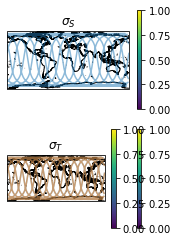

In [704]:
plt.figure
i=0
for vpl in {"T","S"}:
    i+=1
    ax1=plt.subplot(2,2,i, projection=ccrs.PlateCarree())
    ax1.coastlines('50m')
    ax1.plot(swx,swy,alpha=0.5)

    # subset of data
    ipl=1000
    cb=plt.scatter(data_av["x"][::ipl],data_av["y"][::ipl],
                   c=data_std[vpl][::ipl],marker='.',vmin=0,vmax=1)
    plt.colorbar(cb)
    plt.title(r'$\sigma_%s$' % vpl)

    
    i+=1
    ax1=plt.subplot(2,2,i+1, projection=ccrs.PlateCarree())
    ax1.coastlines('50m')
    ax1.plot(swx,swy,alpha=0.5)

    # subset of data
    ipl=1000
    cb=plt.scatter(data_av["x"][::ipl],data_av["y"][::ipl],
                   c=data_av[vpl][::ipl],marker='.',vmin=0,vmax=1)
    plt.colorbar(cb)
    plt.title(r'$\bar_%s$' % vpl)



plt.show()



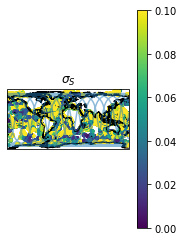

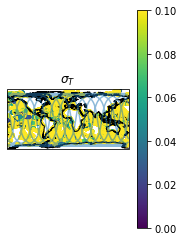

In [722]:
# plot map
def make_plot(x,y,v,vmin=None,vmax=None,title=None,nrows=1,ncols=1,spnum=1):
    ax=plt.subplot(nrows,ncols,spnum, projection=ccrs.PlateCarree())
    
#     plt.subplot(2,2,i, projection=ccrs.PlateCarree())
    ax.coastlines('50m')
    ax.plot(swx,swy,alpha=0.5)
    cb=plt.scatter(x,y,c=v,marker='.',
                  vmin=vmin,vmax=vmax)
    plt.colorbar(cb)
    plt.title(title)


    plt.show()

# -- plot
ipl=1 # subset of data
i=0
nrows=1
ncols=2
for vpl in {"T","S"}:
    i+=1
    ttl=r'$\sigma_%s$' % vpl
    make_plot(data_av["x"][::ipl],data_av["y"][::ipl],data_std[vpl][::ipl],
              vmin=0,vmax=0.1,title=ttl,nrows=nrows,ncols=ncols,spnum=i)


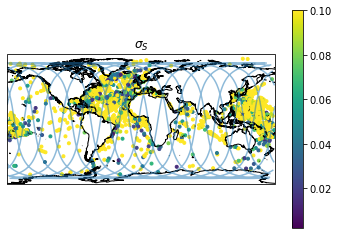

In [738]:
# -- plot
plt.figure
ipl=100 # subset of data

nrows=1
ncols=1
i=1
vpl="S"
ttl=r'$\bar{%s}$' % vpl
ttl=r'$\sigma_{%s}$' % vpl
make_plot(data_av["x"][::ipl],data_av["y"][::ipl],data_std[vpl][::ipl],
          vmin=None,vmax=.1,title=ttl,nrows=nrows,ncols=ncols,spnum=i)


In [734]:
data_av['S'][::ipl]
np.max(data_av['S'][::ipl])

# data_av

39.66990200000001

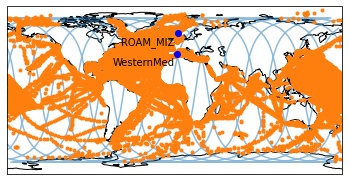

In [141]:
# plot map with regions
ax = plt.axes(projection=ccrs.PlateCarree())
# ax.stock_img()
ax.coastlines()
plt.plot(swx,swy,alpha=0.5)

# tsg data
plt.plot(tsg["x"][::100],tsg["y"][::100],'.')

Nreg=len(regions)
# Nreg=1 # start with first region only
for r in range(Nreg):
    thisreg=regions[r]
    thisx=thisreg.lon
    thisy=thisreg.lat

    plt.plot(thisx, thisy,color='blue', marker='o')
    plt.text(thisx - 3, thisy-12, thisreg.name,
         horizontalalignment='right',
         transform=ccrs.Geodetic())

plt.show()

In [ ]:
# load Matlab format data- doesn't work because Matlab doesn't support python 3.8 ...
# will have to install 3.7 to load/run matlab
# import matlab.engine
if False:
    ddir='/data1/adac/process/'
    fn='adac_tsg_segments_vector.mat'
    print(ddir + fn)
    tsgseg = spio.loadmat(ddir + fn)
    print(tsgseg)

In [112]:
# dict to store data?
sw = dict(x=swx, y=swy)
print(sw)



{'x': masked_array(data=[-61.11147299999999, -53.110487999999975,
                   -45.40966300000002, ..., -78.66973899999999,
                   -71.08508799999998, -63.132780000000025],
             mask=[False, False, False, ..., False, False, False],
       fill_value=1e+20), 'y': array([-77.663122, -77.541863, -77.184958, ..., -77.060339, -77.473841,
       -77.655442])}


In [ ]:
# test

df = pd.DataFrame([[1, 2,2], [3, 4,2]], columns=list('ABC'))
df2 = pd.DataFrame([[5, 6,3], [7, 8,3]], columns=list('ABC'))
df=df.append(df2,ignore_index=True)
print(df)
print()

# test=pd.DataFrame(data=None,columns=datavars)
# test=pd.DataFrame([[1,1,1]], columns=datavars)
test=pd.DataFrame(columns=datavars)
# newdata=pd.Series(data=[1,2,3],index=test.columns)
# # test=test.append(newdata)
# test=test.append(newdata,ignore_index=True)
# test=test.append(newdata,ignore_index=True)
print(test)
newdata2=pd.DataFrame([[8,8,8],[9,9,9]],columns=datavars)
test=test.append(newdata2,ignore_index=True)
print()
print(test)


print()